# CHASV_60model.v2.3, external diabetes and hypertension definition version2
split 7:3

In [1]:
SEED = 0
cores = 16

from numpy.random import seed
seed(SEED)
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from collections import Counter
from sklearn.datasets import make_classification
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std
from xgboost import plot_importance
from matplotlib import pyplot as plt
from numpy import sqrt
from numpy import argmax
from sklearn.metrics import classification_report
import shap
from sklearn.metrics import roc_auc_score
import sklearn.metrics as metrics
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
import seaborn as sns
import joblib
from BorutaShap import BorutaShap
import tqdm

# version check
import sys
print("python version")
print(sys.version)
import sklearn
print("sklearn version = ", sklearn.__version__)
print("numpy version = ", np.__version__)
print("pandas version =", pd.__version__)

python version
3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
sklearn version =  0.23.2
numpy version =  1.19.2
pandas version = 1.2.3


In [2]:
df = pd.read_csv("/home/danssa/proj_ua/data/chasv_development.v2.2.csv", dtype={'id':np.str})
df2 = df.loc[df['from']!="knhanes"]
df2.describe()

,eGFR_ab,eGFR_ckd,male,age,he_uph,he_unitr,he_usg,he_upro,he_uglu,he_uket,he_ubil,he_ubld,he_uro,leucocyte,dm,htn
count,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000
mean,0.067598,93.719380,0.428929,47.179829,6.183206,0.020280,1.018628,0.331024,0.234011,0.205590,0.039356,0.757068,0.168417,0.516135,0.025325,0.039046
std,0.251056,22.147902,0.494924,15.570474,0.824044,0.140957,0.007915,0.769946,0.888690,0.669646,0.324305,1.252923,0.560018,1.024153,0.157111,0.193706
min,0.000000,1.704754,0.000000,18.000000,5.000000,0.000000,1.005000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,80.803010,0.000000,35.000000,5.500000,0.000000,1.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,95.813740,0.000000,45.000000,6.000000,0.000000,1.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,110.264000,1.000000,58.000000,7.000000,0.000000,1.025000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,257.176000,1.000000,95.000000,9.000000,1.000000,1.030000,5.000000,5.000000,5.000000,4.000000,5.000000,5.000000,4.000000,1.000000,1.000000


In [3]:
#3group age split  

##step 1 finding edge value
abnormal_disc = df2.query('eGFR_ab==1').loc[:,'age']
abnormal_disc = pd.DataFrame(abnormal_disc)

est = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans')
est.fit(abnormal_disc)

ab_disc = est.transform(abnormal_disc).astype('float')
print("edges : ", est.bin_edges_[0])

age0_edge = est.bin_edges_[0][1]
age1_edge = est.bin_edges_[0][2]
age2_edge = est.bin_edges_[0][3]
print('age0_edge:', age0_edge, '\nage1_edge:', age1_edge, '\nage2_edge:', age2_edge)

abnormal_disc['level'] = abnormal_disc.apply(lambda x : 0 if x['age']<age0_edge else 1 if x['age']<age1_edge else 2, axis=1)
print('age group:\n',abnormal_disc['level'].value_counts().sort_index())

edges :  [18.         53.80721514 70.94886739 95.        ]
age0_edge: 53.80721513971053 
age1_edge: 70.94886739427912 
age2_edge: 95.0
age group:
 0    2104
1    5505
2    7264
Name: level, dtype: int64


In [4]:
##make 3group by age
df3 = df2.copy()

##age cut set up
df3['level'] = df3.apply(lambda x : 0 if x['age']<age0_edge else 1 if x['age']<age1_edge else 2, axis=1)
print(df3['level'].value_counts())

0    147140
1     52377
2     20503
Name: level, dtype: int64


In [5]:
##age0 group
X_age0 = df3[df3['level']==0]
y_age0 = X_age0['eGFR_ab'].astype("int64")

print('\nage0', X_age0['age'].min(), X_age0['age'].max())
print("total cases = %d" %X_age0.shape[0])
print("total abnormal function of kidney = %d" %sum(y_age0), "\nprevalence =", sum(y_age0)/len(y_age0)*100)

X_train0, X_test0, y_train0, y_test0 = train_test_split(X_age0, y_age0, test_size=0.3, stratify=y_age0, random_state=SEED)
print("train0 : %d" % sum(y_train0), "test0 : %d" % sum(y_test0))

##age1 group
X_age1 = df3[df3['level']==1]
y_age1 = X_age1['eGFR_ab']

print('\nage1', X_age1['age'].min(), X_age1['age'].max())
print("total cases = %d" %X_age1.shape[0])
print("total abnormal function of kidney = %d" %sum(y_age1), "\nprevalence =", sum(y_age1)/len(y_age1)*100)

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_age1, y_age1, test_size=0.3, stratify=y_age1, random_state=SEED)
print("train1 : %d" % sum(y_train1), "test1 : %d" % sum(y_test1))

##age2 group
X_age2 = df3[df3['level']==2]
y_age2 = X_age2['eGFR_ab']

print('\nage2', X_age2['age'].min(), X_age2['age'].max())
print("total cases = %d" %X_age2.shape[0])
print("total abnormal function of kidney = %d" %sum(y_age2), "\nprevalence =", sum(y_age2)/len(y_age2)*100)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_age2, y_age2, test_size=0.3, stratify=y_age2, random_state=SEED)
print("train2 : %d" % sum(y_train2), "test2 : %d" % sum(y_test2))


age0 18 53
total cases = 147140
total abnormal function of kidney = 2104 
prevalence = 1.4299306782655974
train0 : 1473 test0 : 631

age1 54 70
total cases = 52377
total abnormal function of kidney = 5505 
prevalence = 10.510338507360101
train1 : 3853 test1 : 1652

age2 71 95
total cases = 20503
total abnormal function of kidney = 7264 
prevalence = 35.42896161537336
train2 : 5085 test2 : 2179


In [6]:
##concat both trainset and testset
X_train = pd.concat([X_train0, X_train1, X_train2])
y_train = pd.concat([y_train0, y_train1, y_train2])

X_test = pd.concat([X_test0, X_test1, X_test2])
y_test = pd.concat([y_test0, y_test1, y_test2])

print("total cases = %d" % (X_train.shape[0] + X_test.shape[0]))
print("total abnormal function of kidney = %d" % (sum(y_train) + sum(y_test)), "\nprevalence =", (sum(y_train)+sum(y_test))/(len(y_train)+len(y_test))*100)

total cases = 220020
total abnormal function of kidney = 14873 
prevalence = 6.759840014544133


In [7]:
# for psm 
#X_test.to_csv("~/proj_ua/data/cha_test_psm.csv", index=False)

In [8]:
X_train_features = X_train.loc[:, 'male':'leucocyte']

print('%d train cases, %d variables' % (X_train_features.shape[0], X_train_features.shape[1]))
print('%d test cases'%X_test.shape[0])

154013 train cases, 12 variables
66007 test cases


In [9]:
#standardization

scaler = StandardScaler()
std_cols=['age','he_uph','he_usg']
std_df=X_train_features[std_cols]

X_train_features[std_cols]=scaler.fit_transform(std_df)
X_train_features.describe()

,male,age,he_uph,he_unitr,he_usg,he_upro,he_uglu,he_uket,he_ubil,he_ubld,he_uro,leucocyte
count,154013.000000,1.540130e+05,1.540130e+05,154013.000000,1.540130e+05,154013.000000,154013.000000,154013.000000,154013.000000,154013.000000,154013.000000,154013.000000
mean,0.428990,-2.362125e-17,3.380791e-16,0.020492,-1.550439e-14,0.330505,0.234565,0.206749,0.039802,0.754339,0.167538,0.518443
std,0.494933,1.000003e+00,1.000003e+00,0.141676,1.000003e+00,0.768392,0.888223,0.670159,0.325684,1.251279,0.558978,1.026045
min,0.000000,-1.875173e+00,-1.435489e+00,0.000000,-1.720897e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-7.828201e-01,-8.290850e-01,0.000000,-1.089132e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,-1.402599e-01,-2.226811e-01,0.000000,1.743975e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,6.950684e-01,9.901268e-01,0.000000,8.061624e-01,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,1.000000,3.072541e+00,3.415742e+00,1.000000,1.437927e+00,5.000000,5.000000,5.000000,4.000000,5.000000,4.000000,4.000000


In [10]:
#model fit and mean accuracy
def evaluate_model(X, y, model):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=8, random_state=SEED)
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=cores)
    return scores

#model : chasv_60model.v1
model = XGBClassifier(colsample_bytree=0.8000000000000002, gamma=2.0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=500, 
                        objective="binary:logistic", reg_alpha=0, reg_lambda=1, scale_pos_weight=14, subsample=0.2,
                        nthread=6, random_state=SEED).fit(X_train_features, y_train)
scores = evaluate_model(X_train_features, y_train, model)
print('Mean AUC: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean AUC: 0.915 (0.003)


In [11]:
# dimensionality reduction using feature importance
df_imp = pd.DataFrame({'imp':model.feature_importances_}, index = model.get_booster().feature_names)
df_imp = df_imp[df_imp.imp > 0].sort_values('imp').copy()

feat_num = df_imp.shape[0]
print("total number of features =", feat_num)
df_imp

total number of features = 12


,imp
he_uro,0.022157
leucocyte,0.024069
he_uket,0.024328
he_ubil,0.028265
male,0.040014
he_unitr,0.043089
he_uglu,0.056432
he_ubld,0.056874
he_uph,0.057655
he_usg,0.062921


In [12]:
# new model 

## new trainset
X_train_features_new = X_train_features.loc[:, ['male', 'he_usg', 'he_uph', 'he_ubld', 'he_uglu', 'he_upro', 'age']]

## model: chasv_60model.v1
model_new = XGBClassifier(colsample_bytree=0.8000000000000002, gamma=2.0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=500, 
                        objective="binary:logistic", reg_alpha=0, reg_lambda=1, scale_pos_weight=14, subsample=0.2,
                           nthread=6, random_state=SEED).fit(X_train_features_new, y_train)
scores_new = evaluate_model(X_train_features_new, y_train, model_new)
print('Mean AUC of new model : %.3f (%.3f)' % (mean(scores_new), std(scores_new)))

Mean AUC of new model : 0.914 (0.003)


## internal and external validation, All

### internal bootstrap

In [13]:
#testset proteinuria
X_test_features = X_test.loc[:, ['male', 'he_usg', 'he_uph', 'he_ubld', 'he_uglu', 'he_upro', 'age']]
std_df=X_test_features[std_cols]
X_test_features[std_cols]=scaler.transform(std_df)

In [14]:
# for logistic regression, data
lr = X_test.copy()
lr[['std_age', 'std_uph', 'std_usg']] = X_test_features[std_cols]
#lr.to_csv("/home/danssa/proj_ua/data/df_lr_chasv.v1.csv", encoding='utf-8', index=False)

In [15]:
# dataframe for bootstrap
y_prob = model_new.predict_proba(X_test_features)[:,1]
X_test_bs = X_test.copy()
X_test_bs['prob'] = y_prob
X_test_bs

,id,eGFR_ab,eGFR_ckd,male,age,he_uph,he_unitr,he_usg,he_upro,he_uglu,he_uket,he_ubil,he_ubld,he_uro,leucocyte,from,dm,htn,level,prob
664,10509866,0,86.150783,1,52,7.5,0,1.015,0,0,0,0,0,0,0.0,cha,0.0,0.0,0,0.182862
93596,11407061,1,55.096350,0,44,7.0,0,1.005,0,0,0,0,0,0,0.0,cha,0.0,0.0,0,0.070407
29883,10872259,0,117.372900,1,33,5.5,0,1.025,0,0,0,0,0,0,0.0,cha,0.0,0.0,0,0.045959
18763,10730770,0,92.991350,0,19,5.0,0,1.025,2,0,0,0,2,0,3.0,cha,0.0,0.0,0,0.257934
187422,11843382,0,99.844700,1,31,6.0,0,1.030,0,0,0,0,0,0,0.0,cha,0.0,0.0,0,0.026850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276135,2200203,1,40.405110,1,90,5.0,0,1.015,1,2,0,0,0,1,0.0,sv,0.0,0.0,2,0.960947
179982,10974687,1,51.895710,1,79,5.5,0,1.010,0,0,0,0,0,0,0.0,cha,0.0,0.0,2,0.880740
121678,10704951,0,70.768210,1,80,5.0,0,1.010,1,0,0,0,3,0,0.0,cha,0.0,0.0,2,0.956982
45533,11062770,0,62.748080,0,75,5.0,0,1.005,1,0,0,0,4,0,0.0,cha,0.0,0.0,2,0.941138


In [16]:
# test set
data = X_test_bs

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box = []
th_box = []
se_box = []
sp_box = []

for i in range(n_iterations):
    boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab'])
    auc = roc_auc_score(boot['eGFR_ab'], boot['prob'])
    
    auc_box.append(auc)
    
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(boot['eGFR_ab'], boot['prob'])
    J = tpr - fpr
    ix = argmax(J)
    best_thresh, se, sp = thresholds[ix], tpr[ix], 1-fpr[ix]
    
    th_box.append(best_thresh)
    se_box.append(se)
    sp_box.append(sp)

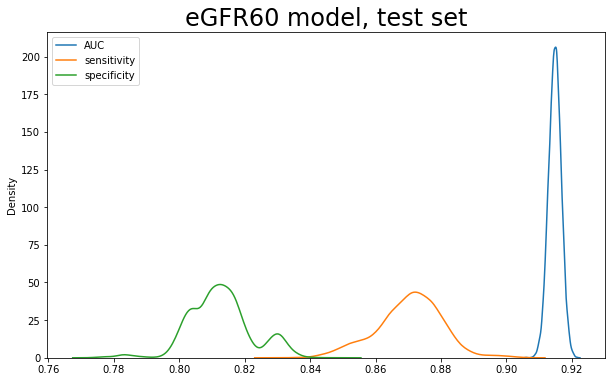

auc mean: 0.91 (0.91-0.92), median:0.91
se  mean: 0.87 (0.85-0.89), median:0.87
sp  mean: 0.81 (0.80-0.83), median:0.81
th  mean: 0.48 (0.45-0.54), median:0.48


In [17]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(auc_box, label='AUC') 
sns.kdeplot(se_box, label='sensitivity')
sns.kdeplot(sp_box, label='specificity')
plt.title("eGFR60 model, test set", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower_auc = max(0.0, np.percentile(auc_box, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_auc = min(1.0, np.percentile(auc_box, p))
print('auc mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(auc_box), lower_auc, upper_auc, np.median(auc_box)))

p = ((1.0-alpha)/2.0) * 100
lower_se = max(0.0, np.percentile(se_box, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_se = min(1.0, np.percentile(se_box, p))
print('se  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(se_box), lower_se, upper_se, np.median(se_box)))

p = ((1.0-alpha)/2.0) * 100
lower_sp = max(0.0, np.percentile(sp_box, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_sp = min(1.0, np.percentile(sp_box, p))
print('sp  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(sp_box), lower_sp, upper_sp, np.median(sp_box)))

p = ((1.0-alpha)/2.0) * 100
lower_th = max(0.0, np.percentile(th_box, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_th = min(1.0, np.percentile(th_box, p))
print('th  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(th_box), lower_th, upper_th, np.median(th_box)))

### external bootstrap

In [18]:
#external validation in knhanes set

ev_wt = pd.read_csv("/home/danssa/proj_ua/data/knhanes_12y.v1.csv")
ev_wt = ev_wt.query('age>=18&age<80')

ev = df[(df['from']=="knhanes") & (df['age']>=18) & (df['age']<80)]
ev['leucocyte'] = np.nan
ev['eGFR_ab'] = np.where(ev['eGFR_ckd']<60,1,0)
ev['wt'] = np.array(ev_wt['wt_12y'])

y_test_ev = ev['eGFR_ab']
print("\nev cases=%d, p cases=%d, ratio=%.2f" % (ev.shape[0], sum(y_test_ev), sum(y_test_ev)/ev.shape[0]*100))

X_test_features_ev = ev.loc[:, ['male', 'he_usg', 'he_uph', 'he_ubld', 'he_uglu', 'he_upro', 'age']]
std_df=X_test_features_ev[std_cols]
X_test_features_ev[std_cols]=scaler.transform(std_df)
print(X_test_features_ev.shape)
X_test_features_ev.describe()


ev cases=62945, p cases=1940, ratio=3.08
(62945, 7)


,male,he_usg,he_uph,he_ubld,he_uglu,he_upro,age
count,62945.000000,62945.000000,62945.000000,62945.000000,62945.000000,62945.000000,62945.000000
mean,0.451696,0.051608,-0.527063,0.579458,0.094305,0.117039,0.142240
std,0.497665,0.784656,1.005067,1.027015,0.539820,0.409067,1.030399
min,0.000000,-1.720897,-1.435489,0.000000,0.000000,0.000000,-1.875173
25%,0.000000,-0.457367,-1.435489,0.000000,0.000000,0.000000,-0.654308
50%,0.000000,0.174398,-0.829085,0.000000,0.000000,0.000000,0.181020
75%,1.000000,0.806162,0.383723,1.000000,0.000000,0.000000,0.952092
max,1.000000,1.437927,3.415742,5.000000,5.000000,5.000000,2.044445


In [19]:
# dataframe for bootstrap, external validation set
y_prob_ev = model_new.predict_proba(X_test_features_ev)[:,1]
X_test_bs_ev = ev.copy()
X_test_bs_ev['prob'] = y_prob_ev
X_test_bs_ev

,id,eGFR_ab,eGFR_ckd,male,age,he_uph,he_unitr,he_usg,he_upro,he_uglu,he_uket,he_ubil,he_ubld,he_uro,leucocyte,from,dm,htn,wt,prob
210862,A901021301,0,76.36104,1,78,5.5,0,1.020,0,0,0,0,0,0,NaN,knhanes,0.0,0.0,320.734691,0.857639
210863,A901021302,0,90.97259,0,75,6.0,0,1.025,0,0,0,0,0,0,NaN,knhanes,0.0,1.0,456.006780,0.792023
210864,A901022601,0,106.45850,0,43,6.0,0,1.020,0,0,0,0,0,0,NaN,knhanes,0.0,0.0,592.556654,0.069273
210865,A901023304,0,85.96295,0,71,6.0,0,1.020,0,4,0,0,0,0,NaN,knhanes,1.0,1.0,288.311428,0.751554
210866,A901023502,0,110.41680,0,42,8.5,0,1.020,0,0,0,0,0,0,NaN,knhanes,0.0,0.0,592.556654,0.049759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273802,P549819801,0,75.12561,0,74,5.0,0,1.025,0,0,0,0,4,0,NaN,knhanes,0.0,0.0,108.891200,0.856111
273803,P549879801,0,71.56396,1,75,5.0,0,1.025,0,0,0,0,2,0,NaN,knhanes,0.0,NaN,201.759400,0.864398
273804,P549879802,0,66.76084,0,74,5.0,0,1.015,0,0,0,0,1,0,NaN,knhanes,0.0,0.0,163.336800,0.883709
273805,P549980702,0,90.97181,0,34,5.0,0,1.030,0,0,0,0,1,0,NaN,knhanes,0.0,0.0,232.329500,0.075743


In [20]:
# load dataset
data = X_test_bs_ev

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_ev = []
th_box_ev = []
se_box_ev = []
sp_box_ev = []

for i in range(n_iterations):
    boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab'])
    auc = roc_auc_score(boot['eGFR_ab'], boot['prob'], sample_weight=boot['wt'])
    
    auc_box_ev.append(auc)
    
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(boot['eGFR_ab'], boot['prob'], sample_weight=boot['wt'])
    J = tpr - fpr
    ix = argmax(J)
    best_thresh, se, sp = thresholds[ix], tpr[ix], 1-fpr[ix]
    
    th_box_ev.append(best_thresh)
    se_box_ev.append(se)
    sp_box_ev.append(sp)

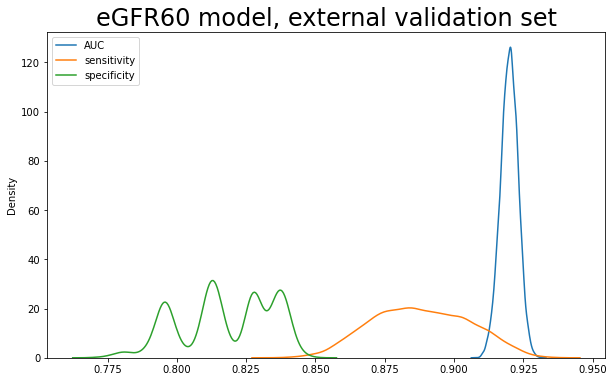

auc mean: 0.92 (0.91-0.93), median:0.92
se  mean: 0.89 (0.86-0.92), median:0.89
sp  mean: 0.82 (0.79-0.84), median:0.82
th  mean: 0.48 (0.42-0.53), median:0.47


In [21]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(auc_box_ev, label='AUC') 
sns.kdeplot(se_box_ev, label='sensitivity')
sns.kdeplot(sp_box_ev, label='specificity')
plt.title("eGFR60 model, external validation set", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower_auc = max(0.0, np.percentile(auc_box_ev, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_auc = min(1.0, np.percentile(auc_box_ev, p))
print('auc mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(auc_box_ev), lower_auc, upper_auc, np.median(auc_box_ev)))

p = ((1.0-alpha)/2.0) * 100
lower_se = max(0.0, np.percentile(se_box_ev, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_se = min(1.0, np.percentile(se_box_ev, p))
print('se  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(se_box_ev), lower_se, upper_se, np.median(se_box_ev)))

p = ((1.0-alpha)/2.0) * 100
lower_sp = max(0.0, np.percentile(sp_box_ev, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_sp = min(1.0, np.percentile(sp_box_ev, p))
print('sp  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(sp_box_ev), lower_sp, upper_sp, np.median(sp_box_ev)))

p = ((1.0-alpha)/2.0) * 100
lower_th = max(0.0, np.percentile(th_box_ev, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_th = min(1.0, np.percentile(th_box_ev, p))
print('th  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(th_box_ev), lower_th, upper_th, np.median(th_box_ev)))

### ROC

#### internal

eGFR60 model

Classification Report

Best Threshold=0.473, sensitivity = 0.87, specificity = 0.81, J=0.682
              precision    recall  f1-score   support

      normal       0.99      0.81      0.89     61545
    abnormal       0.25      0.87      0.39      4462

    accuracy                           0.81     66007
   macro avg       0.62      0.84      0.64     66007
weighted avg       0.94      0.81      0.86     66007



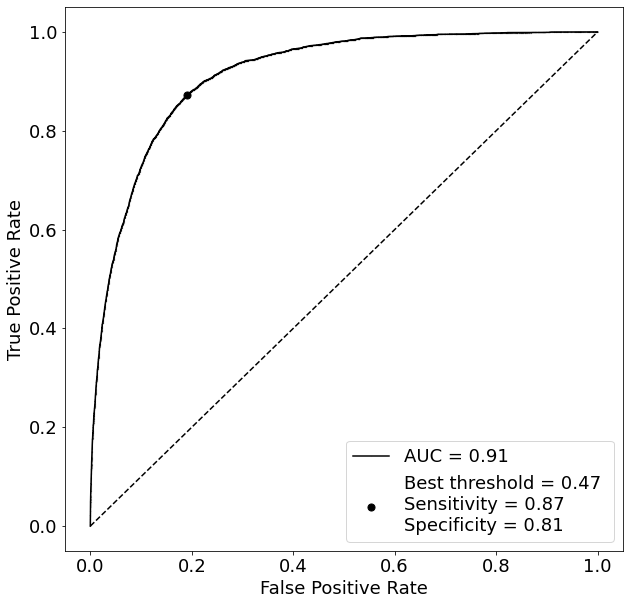

In [22]:
#Youden’s J statistic. / J = Sensitivity + Specificity – 1
y_prob = X_test_bs['prob']
y_test = X_test_bs['eGFR_ab']
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]

print('eGFR60 model')
print('\nClassification Report\n')
print('Best Threshold=%.3f, sensitivity = %.2f, specificity = %.2f, J=%.3f' % (best_thresh, tpr[ix], 1-fpr[ix], J[ix]))

y_prob_pred = (y_prob >= best_thresh).astype(bool)
print(classification_report(y_test, y_prob_pred, target_names=['normal', 'abnormal']))

#plot roc and best threshold
sens, spec = tpr[ix], 1-fpr[ix]
# plot the roc curve for the model
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams["font.size"] = 18
plt.plot([0,1], [0,1], linestyle='--', markersize=0.01, color='black')
plt.plot(fpr, tpr, marker='.', color='black', markersize=0.05, label="AUC = %.2f" % roc_auc_score(y_test, y_prob))
plt.scatter(fpr[ix], tpr[ix], marker='o', s=50, color='k', 
            label='Best threshold = %.2f \nSensitivity = %.2f \nSpecificity = %.2f' % (best_thresh, sens, spec))

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)

# show the plot
plt.show()

#### external

eGFR60 model, knhanes, external validation

Classification Report

Best Threshold=0.497, sensitivity = 0.88, specificity = 0.83, J=0.703
              precision    recall  f1-score   support

      normal       1.00      0.83      0.90 34743760.49391329
    abnormal       0.10      0.88      0.17 726038.3826888512

    accuracy                           0.83 35469798.87660214
   macro avg       0.55      0.85      0.54 35469798.87660214
weighted avg       0.98      0.83      0.89 35469798.87660214



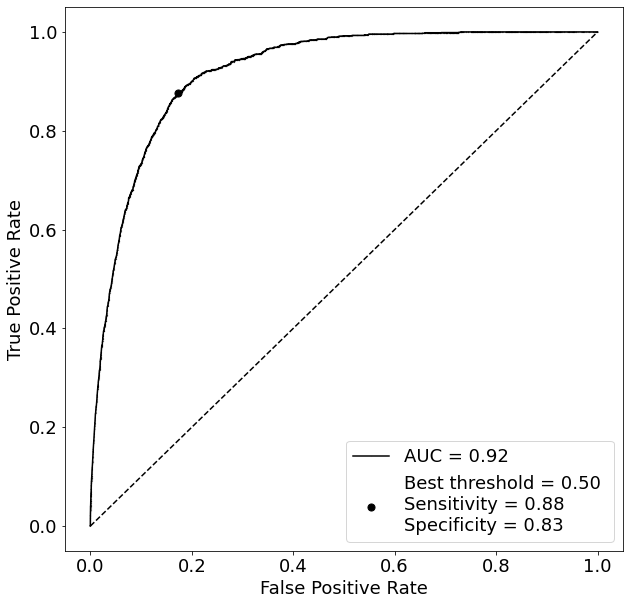

In [23]:
# external validation 

# Youden’s J statistic. / J = Sensitivity + Specificity – 1
y_prob_ev = model_new.predict_proba(X_test_features_ev)[:,1]
# calculate roc curves
fpr_ev, tpr_ev, thresholds_ev = roc_curve(y_test_ev, y_prob_ev, sample_weight=ev['wt'])
# get the best threshold
J_ev = tpr_ev - fpr_ev
ix_ev = argmax(J_ev)
best_thresh_ev = thresholds_ev[ix_ev]

print('eGFR60 model, knhanes, external validation')
print('\nClassification Report\n')
print('Best Threshold=%.3f, sensitivity = %.2f, specificity = %.2f, J=%.3f' % (best_thresh_ev, tpr_ev[ix_ev], 1-fpr_ev[ix_ev], J_ev[ix_ev]))

y_prob_pred_ev = (y_prob_ev >= best_thresh_ev).astype(bool)
print(classification_report(y_test_ev, y_prob_pred_ev, target_names=['normal', 'abnormal'], sample_weight=ev['wt']))

#plot roc and best threshold
sens_ev, spec_ev = tpr_ev[ix_ev], 1-fpr_ev[ix_ev]
# plot the roc curve for the model
plt.rcParams["figure.figsize"] = (10,10)
plt.plot([0,1], [0,1], linestyle='--', markersize=0.01, color='black')
plt.plot(fpr_ev, tpr_ev, marker='.', color='black', markersize=0.05, label="AUC = %.2f" % roc_auc_score(y_test_ev, y_prob_ev, sample_weight=ev['wt']))
plt.scatter(fpr_ev[ix_ev], tpr_ev[ix_ev], marker='o', s=50, color='k', 
            label='Best threshold = %.2f \nSensitivity = %.2f \nSpecificity = %.2f' % (best_thresh_ev, sens_ev, spec_ev))

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)

# show the plot
plt.show()

#### both internal and external

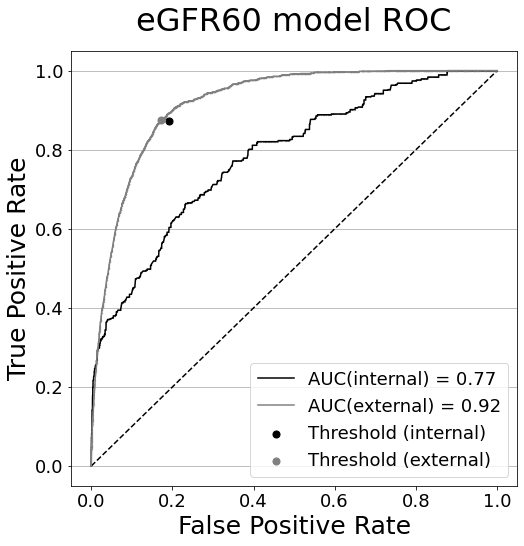

In [128]:
# plot the roc curve for the model
plt.rcParams["figure.figsize"] = (8,8)
plt.plot([0,1], [0,1], linestyle='--', markersize=0.01, color='black')

plt.plot(fpr, tpr, marker='.', color='black', markersize=0.05, label="AUC(internal) = %.2f" % roc_auc_score(y_test, y_prob))
plt.scatter(1-spec, sens, marker='o', s=50, color='k'
            , label='Threshold (internal)' 
            #% (best_thresh)
           )

plt.plot(fpr_ev, tpr_ev, marker='.', color='grey', markersize=0.05, label="AUC(external) = %.2f" % roc_auc_score(y_test_ev, y_prob_ev, sample_weight=ev['wt']))
plt.scatter(1-spec_ev, sens_ev, marker='o', s=50, color='grey'
            , label='Threshold (external)' 
            #% (best_thresh_ev)
           )

# axis labels
plt.xlabel('False Positive Rate', fontsize=25)
plt.ylabel('True Positive Rate', fontsize=25)
plt.legend(loc=4, fontsize=18)
plt.title('eGFR60 model ROC', size=32, pad=20)
# show the plot
#plt.show()

plt.grid(axis='y')
#plt.ylim(1.0)
# save as png
#plt.savefig('/home/danssa/proj_ua/images/5sub/60model_roc.png', dpi=300)

# SHAP value

In [25]:
#SHAP value 

shap.initjs()
print(shap.__version__)

names = pd.read_csv('~/proj_ua/data/knhanes_urine_explain_10types.csv', index_col='var')
background = shap.maskers.Independent(X_train_features_new, max_samples=100)
explainer = shap.TreeExplainer(model_new, model_output='probability', data=X_train_features_new)
shap_values = explainer.shap_values(X_train_features_new)
meaning_dict = names.to_dict()['name']

0.37.0


100%|===================| 153901/154013 [13:50<00:00]        

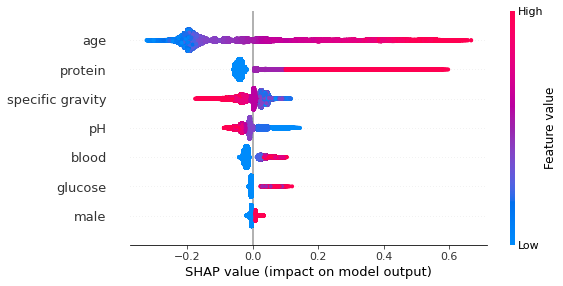

In [26]:
# SHAP, train set
shap.summary_plot(shap_values, X_train_features_new.rename(columns=meaning_dict))

In [27]:
#shap gray version configuration
import matplotlib.colors as colors

gray_val=0.75
cdict = {'red': [(0.0, gray_val, gray_val),
                (1.0, 0.0, 0.0)],
        'green': [(0.0, gray_val, gray_val),
                 (1.0, 0.0, 0.0)],
        'blue': [(0.0, gray_val, gray_val),
                (1.0, 0.0, 0.0)]}
gray2black = colors.LinearSegmentedColormap(name='red', segmentdata=cdict)

In [28]:
# SHAP,test all
shap_values_all = explainer.shap_values(X_test_features)

100%|===================| 65987/66007 [05:56<00:00]        

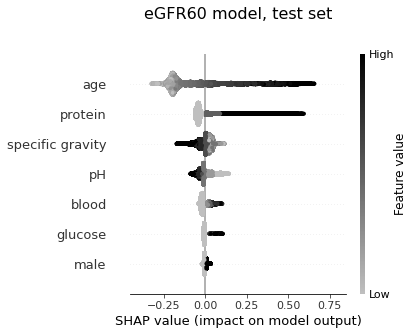

In [29]:
shap.summary_plot(shap_values_all, X_test_features.rename(columns=meaning_dict), show=False, 
                  cmap=plt.get_cmap(gray2black)
                 )
fig = plt.gcf()
fig.set_figheight(5)
fig.set_figwidth(6)

plt.xlim([-0.45,0.85])
plt.title('eGFR60 model, test set', fontsize=16, pad=35)
plt.tight_layout()

plt.grid('off')
plt.grid(b=None)

#save as png
#plt.savefig('/home/danssa/proj_ua/images/5sub/60model_shap.png', dpi=300)

# sub group analysis, internal : DM, HTN, old age, proteinuria

In [30]:
# subset each group
X_test_g1 = X_test_bs.query('dm==1')
X_test_g2 = X_test_bs.query('htn==1')
X_test_g3 = X_test_bs.query('age>=65')
X_test_g4 = X_test_bs.query('he_upro>1')
X_test_g5 = X_test_bs.query('dm==1&age>=65|htn==1&age>=65|he_upro>1&age>=65')

In [31]:
print('total cases, prevalence (cases)')
print('group1: %d, %.1f (%d)' % (len(X_test_g1), sum(X_test_g1['eGFR_ab'])/len(X_test_g1)*100, sum(X_test_g1['eGFR_ab'])))
print('group2: %d, %.1f (%d)' % (len(X_test_g2), sum(X_test_g2['eGFR_ab'])/len(X_test_g2)*100, sum(X_test_g2['eGFR_ab'])))
print('group3: %d, %.1f (%d)' % (len(X_test_g3), sum(X_test_g3['eGFR_ab'])/len(X_test_g3)*100, sum(X_test_g3['eGFR_ab'])))
print('group4: %d, %.1f (%d)' % (len(X_test_g4), sum(X_test_g4['eGFR_ab'])/len(X_test_g4)*100, sum(X_test_g4['eGFR_ab'])))
print('group5: %d, %.1f (%d)' % (len(X_test_g5), sum(X_test_g5['eGFR_ab'])/len(X_test_g5)*100, sum(X_test_g5['eGFR_ab'])))

total cases, prevalence (cases)
group1: 1630, 4.5 (74)
group2: 2642, 2.2 (58)
group3: 10742, 27.8 (2991)
group4: 5651, 26.0 (1467)
group5: 2184, 41.0 (895)


In [32]:
print('train old age & diabetes', 
      sum(X_train.query('age>=65&dm==1')['eGFR_ab'])/len(X_train.query('age>=65&dm==1')),
      sum(X_train.query('age>=65&dm==0')['eGFR_ab'])/len(X_train.query('age>=65&dm==0')))

train old age & diabetes 0.1488095238095238 0.28669868448527874


In [33]:
print('test old age & diabetes',
      sum(X_test_g3.query('dm==1')['eGFR_ab'])/len(X_test_g3.query('dm==1')),
      sum(X_test_g3.query('dm==0')['eGFR_ab'])/len(X_test_g3.query('dm==0')))

test old age & diabetes 0.13529411764705881 0.28311863103249374


## sub1 : DM

In [34]:
# test set
data = X_test_g1

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_s1 = []
th_box_s1 = []
se_box_s1 = []
sp_box_s1 = []

for i in range(n_iterations):
    boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab'])
    auc = roc_auc_score(boot['eGFR_ab'], boot['prob'])
    
    auc_box_s1.append(auc)
    
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(boot['eGFR_ab'], boot['prob'])
    J = tpr - fpr
    ix = argmax(J)
    best_thresh, se, sp = thresholds[ix], tpr[ix], 1-fpr[ix]
    
    th_box_s1.append(best_thresh)
    se_box_s1.append(se)
    sp_box_s1.append(sp)

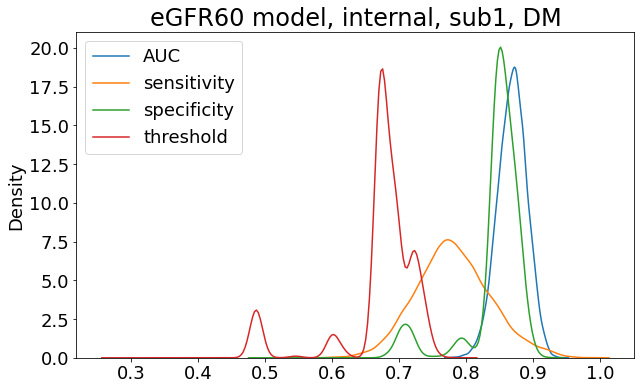

auc mean: 0.87 (0.82-0.91), median:0.87
se  mean: 0.78 (0.68-0.89), median:0.78
sp  mean: 0.84 (0.70-0.89), median:0.85
th  mean: 0.67 (0.49-0.74), median:0.69


In [35]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(auc_box_s1, label='AUC') 
sns.kdeplot(se_box_s1, label='sensitivity')
sns.kdeplot(sp_box_s1, label='specificity')
sns.kdeplot(th_box_s1, label='threshold')
plt.title("eGFR60 model, internal, sub1, DM", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower_auc = max(0.0, np.percentile(auc_box_s1, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_auc = min(1.0, np.percentile(auc_box_s1, p))
print('auc mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(auc_box_s1), lower_auc, upper_auc, np.median(auc_box_s1)))

p = ((1.0-alpha)/2.0) * 100
lower_se = max(0.0, np.percentile(se_box_s1, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_se = min(1.0, np.percentile(se_box_s1, p))
print('se  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(se_box_s1), lower_se, upper_se, np.median(se_box_s1)))

p = ((1.0-alpha)/2.0) * 100
lower_sp = max(0.0, np.percentile(sp_box_s1, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_sp = min(1.0, np.percentile(sp_box_s1, p))
print('sp  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(sp_box_s1), lower_sp, upper_sp, np.median(sp_box_s1)))

p = ((1.0-alpha)/2.0) * 100
lower_th = max(0.0, np.percentile(th_box_s1, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_th = min(1.0, np.percentile(th_box_s1, p))
print('th  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(th_box_s1), lower_th, upper_th, np.median(th_box_s1)))

In [36]:
#Youden’s J statistic. / J = Sensitivity + Specificity – 1
y_prob = X_test_g1['prob']
y_test = X_test_g1['eGFR_ab']

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('eGFR60 model, group1')
print('AUC         : %.2f\nsensitivity : %.2f\nspecificity : %.2f\nThreshold   : %.2f' 
      % (roc_auc_score(y_test, y_prob), tpr[ix], 1-fpr[ix], best_thresh))

print('\nClassification Report\n')
y_prob_pred = (y_prob >= best_thresh).astype(bool)
print(classification_report(y_test, y_prob_pred, target_names=['normal', 'abnormal']))

eGFR60 model, group1
AUC         : 0.87
sensitivity : 0.77
specificity : 0.85
Threshold   : 0.67

Classification Report

              precision    recall  f1-score   support

      normal       0.99      0.85      0.91      1556
    abnormal       0.19      0.77      0.31        74

    accuracy                           0.84      1630
   macro avg       0.59      0.81      0.61      1630
weighted avg       0.95      0.84      0.88      1630



## sub2 : HTN

In [37]:
# test set
data = X_test_g2

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_s2 = []
th_box_s2 = []
se_box_s2 = []
sp_box_s2 = []

for i in range(n_iterations):
    boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab'])
    auc = roc_auc_score(boot['eGFR_ab'], boot['prob'])
    
    auc_box_s2.append(auc)
    
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(boot['eGFR_ab'], boot['prob'])
    J = tpr - fpr
    ix = argmax(J)
    best_thresh, se, sp = thresholds[ix], tpr[ix], 1-fpr[ix]
    
    th_box_s2.append(best_thresh)
    se_box_s2.append(se)
    sp_box_s2.append(sp)

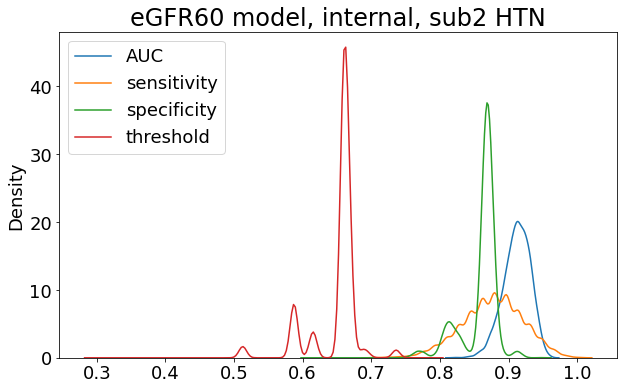

auc mean: 0.91 (0.87-0.95), median:0.91
se  mean: 0.88 (0.79-0.97), median:0.88
sp  mean: 0.86 (0.79-0.89), median:0.87
th  mean: 0.65 (0.59-0.69), median:0.66


In [38]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(auc_box_s2, label='AUC') 
sns.kdeplot(se_box_s2, label='sensitivity')
sns.kdeplot(sp_box_s2, label='specificity')
sns.kdeplot(th_box_s2, label="threshold")
plt.title("eGFR60 model, internal, sub2 HTN", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower_auc = max(0.0, np.percentile(auc_box_s2, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_auc = min(1.0, np.percentile(auc_box_s2, p))
print('auc mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(auc_box_s2), lower_auc, upper_auc, np.median(auc_box_s2)))

p = ((1.0-alpha)/2.0) * 100
lower_se = max(0.0, np.percentile(se_box_s2, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_se = min(1.0, np.percentile(se_box_s2, p))
print('se  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(se_box_s2), lower_se, upper_se, np.median(se_box_s2)))

p = ((1.0-alpha)/2.0) * 100
lower_sp = max(0.0, np.percentile(sp_box_s2, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_sp = min(1.0, np.percentile(sp_box_s2, p))
print('sp  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(sp_box_s2), lower_sp, upper_sp, np.median(sp_box_s2)))

p = ((1.0-alpha)/2.0) * 100
lower_th = max(0.0, np.percentile(th_box_s2, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_th = min(1.0, np.percentile(th_box_s2, p))
print('th  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(th_box_s2), lower_th, upper_th, np.median(th_box_s2)))

In [39]:
#Youden’s J statistic. / J = Sensitivity + Specificity – 1
y_prob = X_test_g2['prob']
y_test = X_test_g2['eGFR_ab']

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('eGFR60 model, group2')
print('AUC         : %.2f\nsensitivity : %.2f\nspecificity : %.2f\nThreshold   : %.2f' 
      % (roc_auc_score(y_test, y_prob), tpr[ix], 1-fpr[ix], best_thresh))

print('\nClassification Report\n')
y_prob_pred = (y_prob >= best_thresh).astype(bool)
print(classification_report(y_test, y_prob_pred, target_names=['normal', 'abnormal']))

eGFR60 model, group2
AUC         : 0.91
sensitivity : 0.86
specificity : 0.87
Threshold   : 0.66

Classification Report

              precision    recall  f1-score   support

      normal       1.00      0.87      0.93      2584
    abnormal       0.13      0.86      0.22        58

    accuracy                           0.87      2642
   macro avg       0.56      0.86      0.57      2642
weighted avg       0.98      0.87      0.91      2642



## sub3 : old age, age>=65

In [40]:
# test set
data = X_test_g3

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_s3 = []
th_box_s3 = []
se_box_s3 = []
sp_box_s3 = []

for i in range(n_iterations):
    boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab'])
    auc = roc_auc_score(boot['eGFR_ab'], boot['prob'])
    
    auc_box_s3.append(auc)
    
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(boot['eGFR_ab'], boot['prob'])
    J = tpr - fpr
    ix = argmax(J)
    best_thresh, se, sp = thresholds[ix], tpr[ix], 1-fpr[ix]
    
    th_box_s3.append(best_thresh)
    se_box_s3.append(se)
    sp_box_s3.append(sp)

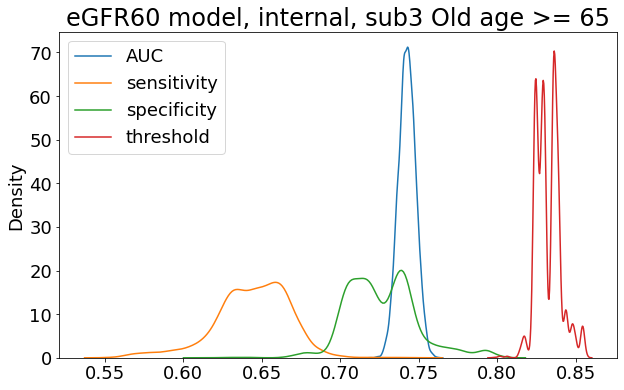

auc mean: 0.74 (0.73-0.75), median:0.74
se  mean: 0.64 (0.58-0.68), median:0.65
sp  mean: 0.73 (0.69-0.78), median:0.72
th  mean: 0.83 (0.82-0.85), median:0.83


In [41]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(auc_box_s3, label='AUC') 
sns.kdeplot(se_box_s3, label='sensitivity')
sns.kdeplot(sp_box_s3, label='specificity')
sns.kdeplot(th_box_s3, label='threshold')
plt.title("eGFR60 model, internal, sub3 Old age >= 65", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower_auc = max(0.0, np.percentile(auc_box_s3, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_auc = min(1.0, np.percentile(auc_box_s3, p))
print('auc mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(auc_box_s3), lower_auc, upper_auc, np.median(auc_box_s3)))

p = ((1.0-alpha)/2.0) * 100
lower_se = max(0.0, np.percentile(se_box_s3, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_se = min(1.0, np.percentile(se_box_s3, p))
print('se  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(se_box_s3), lower_se, upper_se, np.median(se_box_s3)))

p = ((1.0-alpha)/2.0) * 100
lower_sp = max(0.0, np.percentile(sp_box_s3, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_sp = min(1.0, np.percentile(sp_box_s3, p))
print('sp  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(sp_box_s3), lower_sp, upper_sp, np.median(sp_box_s3)))

p = ((1.0-alpha)/2.0) * 100
lower_th = max(0.0, np.percentile(th_box_s3, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_th = min(1.0, np.percentile(th_box_s3, p))
print('th  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(th_box_s3), lower_th, upper_th, np.median(th_box_s3)))

In [42]:
#Youden’s J statistic. / J = Sensitivity + Specificity – 1
y_prob = X_test_g3['prob']
y_test = X_test_g3['eGFR_ab']

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('eGFR60 model, group3')
print('AUC         : %.2f\nsensitivity : %.2f\nspecificity : %.2f\nThreshold   : %.2f' 
      % (roc_auc_score(y_test, y_prob), tpr[ix], 1-fpr[ix], best_thresh))

print('\nClassification Report\n')
y_prob_pred = (y_prob >= best_thresh).astype(bool)
print(classification_report(y_test, y_prob_pred, target_names=['normal', 'abnormal']))

eGFR60 model, group3
AUC         : 0.74
sensitivity : 0.63
specificity : 0.74
Threshold   : 0.84

Classification Report

              precision    recall  f1-score   support

      normal       0.84      0.74      0.78      7751
    abnormal       0.48      0.63      0.55      2991

    accuracy                           0.71     10742
   macro avg       0.66      0.68      0.66     10742
weighted avg       0.74      0.71      0.72     10742



## sub4 : proteinuria

In [43]:
# test set
data = X_test_g4

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_s4 = []
th_box_s4 = []
se_box_s4 = []
sp_box_s4 = []

for i in range(n_iterations):
    boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab'])
    auc = roc_auc_score(boot['eGFR_ab'], boot['prob'])
    
    auc_box_s4.append(auc)
    
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(boot['eGFR_ab'], boot['prob'])
    J = tpr - fpr
    ix = argmax(J)
    best_thresh, se, sp = thresholds[ix], tpr[ix], 1-fpr[ix]
    
    th_box_s4.append(best_thresh)
    se_box_s4.append(se)
    sp_box_s4.append(sp)

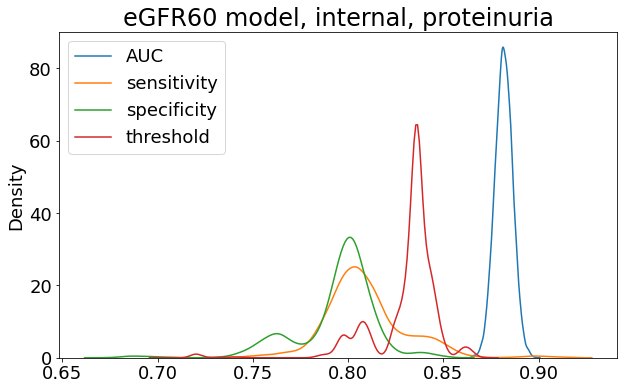

auc mean: 0.88 (0.87-0.89), median:0.88
se  mean: 0.81 (0.77-0.85), median:0.81
sp  mean: 0.79 (0.75-0.83), median:0.80
th  mean: 0.83 (0.80-0.86), median:0.84


In [44]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(auc_box_s4, label='AUC') 
sns.kdeplot(se_box_s4, label='sensitivity')
sns.kdeplot(sp_box_s4, label='specificity')
sns.kdeplot(th_box_s4, label='threshold')
plt.title("eGFR60 model, internal, proteinuria", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower_auc = max(0.0, np.percentile(auc_box_s4, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_auc = min(1.0, np.percentile(auc_box_s4, p))
print('auc mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(auc_box_s4), lower_auc, upper_auc, np.median(auc_box_s4)))

p = ((1.0-alpha)/2.0) * 100
lower_se = max(0.0, np.percentile(se_box_s4, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_se = min(1.0, np.percentile(se_box_s4, p))
print('se  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(se_box_s4), lower_se, upper_se, np.median(se_box_s4)))

p = ((1.0-alpha)/2.0) * 100
lower_sp = max(0.0, np.percentile(sp_box_s4, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_sp = min(1.0, np.percentile(sp_box_s4, p))
print('sp  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(sp_box_s4), lower_sp, upper_sp, np.median(sp_box_s4)))

p = ((1.0-alpha)/2.0) * 100
lower_th = max(0.0, np.percentile(th_box_s4, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_th = min(1.0, np.percentile(th_box_s4, p))
print('th  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(th_box_s4), lower_th, upper_th, np.median(th_box_s4)))

In [45]:
#Youden’s J statistic. / J = Sensitivity + Specificity – 1
y_prob = X_test_g4['prob']
y_test = X_test_g4['eGFR_ab']

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('eGFR60 model, group4')
print('AUC         : %.2f\nsensitivity : %.2f\nspecificity : %.2f\nThreshold   : %.2f' 
      % (roc_auc_score(y_test, y_prob), tpr[ix], 1-fpr[ix], best_thresh))

print('\nClassification Report\n')
y_prob_pred = (y_prob >= best_thresh).astype(bool)
print(classification_report(y_test, y_prob_pred, target_names=['normal', 'abnormal']))

eGFR60 model, group4
AUC         : 0.88
sensitivity : 0.80
specificity : 0.80
Threshold   : 0.84

Classification Report

              precision    recall  f1-score   support

      normal       0.92      0.80      0.86      4184
    abnormal       0.58      0.80      0.68      1467

    accuracy                           0.80      5651
   macro avg       0.75      0.80      0.77      5651
weighted avg       0.83      0.80      0.81      5651



## sub5 : age>=65 and (dm or htn or proteinuria)

In [46]:
# test set
data = X_test_g5

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_s4 = []
th_box_s4 = []
se_box_s4 = []
sp_box_s4 = []

for i in range(n_iterations):
    boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab'])
    auc = roc_auc_score(boot['eGFR_ab'], boot['prob'])
    
    auc_box_s4.append(auc)
    
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(boot['eGFR_ab'], boot['prob'])
    J = tpr - fpr
    ix = argmax(J)
    best_thresh, se, sp = thresholds[ix], tpr[ix], 1-fpr[ix]
    
    th_box_s4.append(best_thresh)
    se_box_s4.append(se)
    sp_box_s4.append(sp)

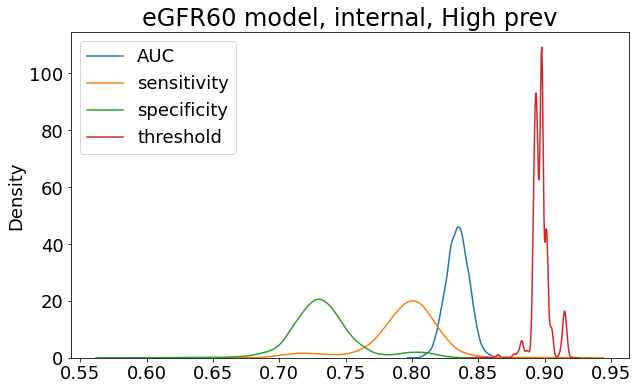

auc mean: 0.83 (0.82-0.85), median:0.83
se  mean: 0.79 (0.71-0.84), median:0.80
sp  mean: 0.73 (0.69-0.81), median:0.73
th  mean: 0.90 (0.88-0.92), median:0.90


In [47]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(auc_box_s4, label='AUC') 
sns.kdeplot(se_box_s4, label='sensitivity')
sns.kdeplot(sp_box_s4, label='specificity')
sns.kdeplot(th_box_s4, label='threshold')
plt.title("eGFR60 model, internal, High prev", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower_auc = max(0.0, np.percentile(auc_box_s4, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_auc = min(1.0, np.percentile(auc_box_s4, p))
print('auc mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(auc_box_s4), lower_auc, upper_auc, np.median(auc_box_s4)))

p = ((1.0-alpha)/2.0) * 100
lower_se = max(0.0, np.percentile(se_box_s4, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_se = min(1.0, np.percentile(se_box_s4, p))
print('se  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(se_box_s4), lower_se, upper_se, np.median(se_box_s4)))

p = ((1.0-alpha)/2.0) * 100
lower_sp = max(0.0, np.percentile(sp_box_s4, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_sp = min(1.0, np.percentile(sp_box_s4, p))
print('sp  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(sp_box_s4), lower_sp, upper_sp, np.median(sp_box_s4)))

p = ((1.0-alpha)/2.0) * 100
lower_th = max(0.0, np.percentile(th_box_s4, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_th = min(1.0, np.percentile(th_box_s4, p))
print('th  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(th_box_s4), lower_th, upper_th, np.median(th_box_s4)))

In [48]:
#Youden’s J statistic. / J = Sensitivity + Specificity – 1
y_prob = X_test_g5['prob']
y_test = X_test_g5['eGFR_ab']

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('eGFR60 model, group5')
print('AUC         : %.2f\nsensitivity : %.2f\nspecificity : %.2f\nThreshold   : %.2f' 
      % (roc_auc_score(y_test, y_prob), tpr[ix], 1-fpr[ix], best_thresh))

print('\nClassification Report\n')
y_prob_pred = (y_prob >= best_thresh).astype(bool)
print(classification_report(y_test, y_prob_pred, target_names=['normal', 'abnormal']))

eGFR60 model, group5
AUC         : 0.83
sensitivity : 0.79
specificity : 0.73
Threshold   : 0.90

Classification Report

              precision    recall  f1-score   support

      normal       0.84      0.73      0.78      1289
    abnormal       0.67      0.79      0.73       895

    accuracy                           0.76      2184
   macro avg       0.75      0.76      0.75      2184
weighted avg       0.77      0.76      0.76      2184



## accuracy in eGFR<60, eGFR<45 and eGFR<30

### internal

### all

In [49]:
X_test_bs['pred'] = np.where(X_test_bs['prob']>=0.48, 1, 0)
X_test_bs['pred'].value_counts()

# 60
X_test_bs60 = X_test_bs.query('eGFR_ckd<60')
X_test_bs60['acc'] = X_test_bs60['eGFR_ab'] == X_test_bs60['pred']
print('60all: %d right: %d ratio: %.1f' % (len(X_test_bs60), sum(X_test_bs60['acc']), sum(X_test_bs60['acc'])/len(X_test_bs60)*100))

#45
X_test_bs45 = X_test_bs.query('eGFR_ckd<45')
X_test_bs45['eGFR_ab45'] = np.where(X_test_bs45['eGFR_ckd']<45,1,0)
X_test_bs45['acc'] = X_test_bs45['eGFR_ab45'] == X_test_bs45['pred']
print('45all: %d right: %d ratio: %.1f' % (len(X_test_bs45), sum(X_test_bs45['acc']), sum(X_test_bs45['acc'])/len(X_test_bs45)*100))

#30
X_test_bs30 = X_test_bs.query('eGFR_ckd<30')
X_test_bs30['eGFR_ab30'] = np.where(X_test_bs30['eGFR_ckd']<30,1,0)
X_test_bs30['acc'] = X_test_bs30['eGFR_ab30'] == X_test_bs30['pred']
print('30all: %d right: %d ratio: %.1f' % (len(X_test_bs30), sum(X_test_bs30['acc']), sum(X_test_bs30['acc'])/len(X_test_bs30)*100))

60all: 4462 right: 3879 ratio: 86.9
45all: 1954 right: 1815 ratio: 92.9
30all: 915 right: 873 ratio: 95.4


In [50]:
# confidence intervals
def cical(box, alpha=0.95):
    p = ((1.0-alpha)/2.0)*100
    lower = max(0.0, np.percentile(box, p))
    p = (alpha+((1.0-alpha)/2.0))*100
    upper = min(1.0, np.percentile(box, p))
   # mean = mean(box)
    median = np.median(box)
    
    return print('mean(ci): %.2f (%.2f-%.2f), median:%.2f' % (mean(box), lower, upper, np.median(box)))

In [51]:
# test set
data = X_test_bs60

# configure bootstrap
n_iterations = 10000
# n_size = len(data)

# run bootstrap
se_all_60, acc = [], []
se_all_45, acc45 = [], []
se_all_30, acc30 = [], []

with tqdm.tqdm(total=len(data)) as pbar:
    for i in range(n_iterations):
        # 60
        boot = resample(data, n_samples=n_size, replace=True, 
                        #stratify=data['eGFR_ab']
                       )
        acc = boot['eGFR_ab'] == boot['pred']
        se = sum(acc)/len(boot)
        se_all_60.append(se)
        
        # 45
        data45 = data.query('eGFR_ckd<45')
        boot45 = resample(data45, n_samples=len(data45), replace=True)
        boot45['eGFR_ab45'] = np.where(boot45['eGFR_ckd']<45,1,0)
        acc45 = boot45['eGFR_ab45'] == boot45['pred']
        se45 = sum(acc45)/len(boot45)
        se_all_45.append(se45)
        
        # 30
        data30 = data.query('eGFR_ckd<30')
        boot30 = resample(data30, n_samples=len(data30), replace=True)
        boot30['eGFR_ab30'] = np.where(boot30['eGFR_ckd']<30,1,0)
        acc30 = boot30['eGFR_ab30'] == boot30['pred']
        se30 = sum(acc30)/len(boot30)
        se_all_30.append(se30)
        
        pbar.update()

10000it [01:01, 162.48it/s]                         


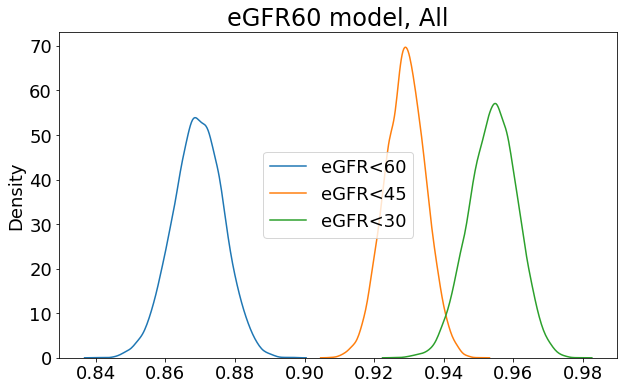

mean(ci): 0.87 (0.85-0.88), median:0.87
mean(ci): 0.93 (0.92-0.94), median:0.93
mean(ci): 0.95 (0.94-0.97), median:0.95


In [52]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(se_all_60, label='eGFR<60') 
sns.kdeplot(se_all_45, label='eGFR<45') 
sns.kdeplot(se_all_30, label='eGFR<30') 
plt.title("eGFR60 model, All", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

cical(se_all_60)
cical(se_all_45)
cical(se_all_30)

### group1, diabetes

In [53]:
X_test_g1['pred'] = np.where(X_test_g1['prob']>=0.67, 1, 0)
X_test_g1['pred'].value_counts()

# 60
X_test_g160 = X_test_g1.query('eGFR_ckd<60')
X_test_g160['acc'] = X_test_g160['eGFR_ab'] == X_test_g160['pred']
print('60all: %d right: %d ratio: %.1f' % (len(X_test_g160), sum(X_test_g160['acc']), sum(X_test_g160['acc'])/len(X_test_g160)*100))

#45
X_test_g145 = X_test_g1.query('eGFR_ckd<45')
X_test_g145['eGFR_ab45'] = np.where(X_test_g145['eGFR_ckd']<45,1,0)
X_test_g145['acc'] = X_test_g145['eGFR_ab45'] == X_test_g145['pred']
print('45all: %d right: %d ratio: %.1f' % (len(X_test_g145), sum(X_test_g145['acc']), sum(X_test_g145['acc'])/len(X_test_g145)*100))

#30
X_test_g130 = X_test_g1.query('eGFR_ckd<30')
X_test_g130['eGFR_ab30'] = np.where(X_test_g130['eGFR_ckd']<30,1,0)
X_test_g130['acc'] = X_test_g130['eGFR_ab30'] == X_test_g130['pred']
print('30all: %d right: %d ratio: %.1f' % (len(X_test_g130), sum(X_test_g130['acc']), sum(X_test_g130['acc'])/len(X_test_g130)*100))

60all: 74 right: 57 ratio: 77.0
45all: 30 right: 25 ratio: 83.3
30all: 18 right: 15 ratio: 83.3


In [54]:
# test set
data = X_test_g160

# configure bootstrap
n_iterations = 10000
# n_size = len(data)

# run bootstrap
se_g1_60, acc = [], []
se_g1_45, acc45 = [], []
se_g1_30, acc30 = [], []

with tqdm.tqdm(total=len(data)) as pbar:
    for i in range(n_iterations):
        # 60
        boot = resample(data, n_samples=n_size, replace=True, 
                        #stratify=data['eGFR_ab']
                       )
        acc = boot['eGFR_ab'] == boot['pred']
        se = sum(acc)/len(boot)
        se_g1_60.append(se)
        
        # 45
        data45 = data.query('eGFR_ckd<45')
        boot45 = resample(data45, n_samples=len(data45), replace=True)
        boot45['eGFR_ab45'] = np.where(boot45['eGFR_ckd']<45,1,0)
        acc45 = boot45['eGFR_ab45'] == boot45['pred']
        se45 = sum(acc45)/len(boot45)
        se_g1_45.append(se45)
        
        # 30
        data30 = data.query('eGFR_ckd<30')
        boot30 = resample(data30, n_samples=len(data30), replace=True)
        boot30['eGFR_ab30'] = np.where(boot30['eGFR_ckd']<30,1,0)
        acc30 = boot30['eGFR_ab30'] == boot30['pred']
        se30 = sum(acc30)/len(boot30)
        se_g1_30.append(se30)
        
        pbar.update()

10000it [00:55, 181.08it/s]                     


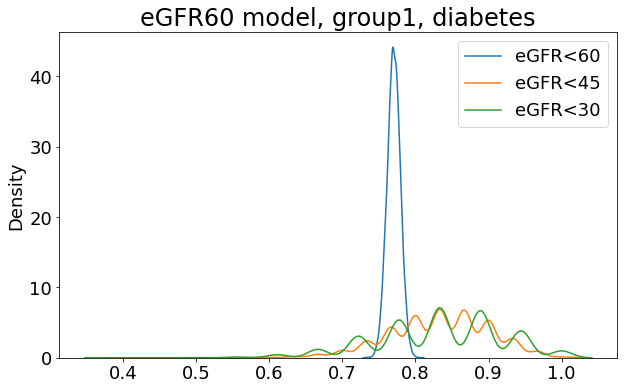

mean(ci): 0.77 (0.75-0.79), median:0.77
mean(ci): 0.83 (0.70-0.97), median:0.83
mean(ci): 0.83 (0.67-1.00), median:0.83


In [55]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(se_g1_60, label='eGFR<60') 
sns.kdeplot(se_g1_45, label='eGFR<45') 
sns.kdeplot(se_g1_30, label='eGFR<30') 
plt.title("eGFR60 model, group1, diabetes", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

cical(se_g1_60)
cical(se_g1_45)
cical(se_g1_30)

### group2, hypertension

In [56]:
X_test_g2['pred'] = np.where(X_test_g2['prob']>=0.65, 1, 0)
X_test_g2['pred'].value_counts()

# 60
X_test_g260 = X_test_g2.query('eGFR_ckd<60')
X_test_g260['acc'] = X_test_g260['eGFR_ab'] == X_test_g260['pred']
print('60all: %d right: %d ratio: %.1f' % (len(X_test_g260), sum(X_test_g260['acc']), sum(X_test_g260['acc'])/len(X_test_g260)*100))

#45
X_test_g245 = X_test_g2.query('eGFR_ckd<45')
X_test_g245['eGFR_ab45'] = np.where(X_test_g245['eGFR_ckd']<45,1,0)
X_test_g245['acc'] = X_test_g245['eGFR_ab45'] == X_test_g245['pred']
print('45all: %d right: %d ratio: %.1f' % (len(X_test_g245), sum(X_test_g245['acc']), sum(X_test_g245['acc'])/len(X_test_g245)*100))

#30
X_test_g230 = X_test_g2.query('eGFR_ckd<30')
X_test_g230['eGFR_ab30'] = np.where(X_test_g230['eGFR_ckd']<30,1,0)
X_test_g230['acc'] = X_test_g230['eGFR_ab30'] == X_test_g230['pred']
print('30all: %d right: %d ratio: %.1f' % (len(X_test_g230), sum(X_test_g230['acc']), sum(X_test_g230['acc'])/len(X_test_g230)*100))

60all: 58 right: 50 ratio: 86.2
45all: 18 right: 18 ratio: 100.0
30all: 9 right: 9 ratio: 100.0


In [57]:
# test set
data = X_test_g260

# configure bootstrap
n_iterations = 10000
# n_size = len(data)

# run bootstrap
se_g2_60, acc = [], []
se_g2_45, acc45 = [], []
se_g2_30, acc30 = [], []

with tqdm.tqdm(total=len(data)) as pbar:
    for i in range(n_iterations):
        # 60
        boot = resample(data, n_samples=n_size, replace=True, 
                        #stratify=data['eGFR_ab']
                       )
        acc = boot['eGFR_ab'] == boot['pred']
        se = sum(acc)/len(boot)
        se_g2_60.append(se)
        
        # 45
        data45 = data.query('eGFR_ckd<45')
        boot45 = resample(data45, n_samples=len(data45), replace=True)
        boot45['eGFR_ab45'] = np.where(boot45['eGFR_ckd']<45,1,0)
        acc45 = boot45['eGFR_ab45'] == boot45['pred']
        se45 = sum(acc45)/len(boot45)
        se_g2_45.append(se45)
        
        # 30
        data30 = data.query('eGFR_ckd<30')
        boot30 = resample(data30, n_samples=len(data30), replace=True)
        boot30['eGFR_ab30'] = np.where(boot30['eGFR_ckd']<30,1,0)
        acc30 = boot30['eGFR_ab30'] == boot30['pred']
        se30 = sum(acc30)/len(boot30)
        se_g2_30.append(se30)
        
        pbar.update()

10000it [00:53, 188.20it/s]                     


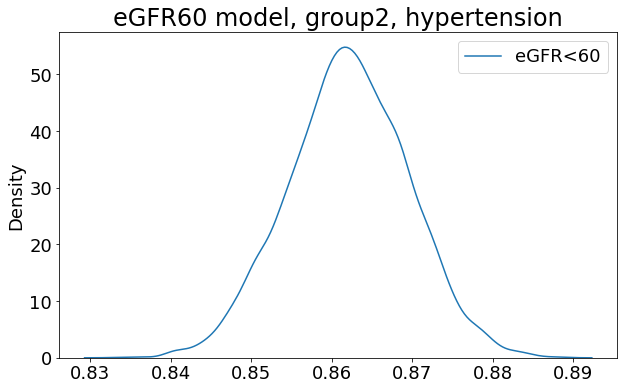

mean(ci): 0.86 (0.85-0.88), median:0.86
mean(ci): 1.00 (1.00-1.00), median:1.00
mean(ci): 1.00 (1.00-1.00), median:1.00


In [58]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(se_g2_60, label='eGFR<60') 
sns.kdeplot(se_g2_45, label='eGFR<45') 
sns.kdeplot(se_g2_30, label='eGFR<30') 
plt.title("eGFR60 model, group2, hypertension", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

cical(se_g2_60)
cical(se_g2_45)
cical(se_g2_30)

### group3, old age >= 65

In [59]:
X_test_g3['pred'] = np.where(X_test_g3['prob']>=0.83, 1, 0)
X_test_g3['pred'].value_counts()

# 60
X_test_g360 = X_test_g3.query('eGFR_ckd<60')
X_test_g360['acc'] = X_test_g360['eGFR_ab'] == X_test_g360['pred']
print('60all: %d right: %d ratio: %.1f' % (len(X_test_g360), sum(X_test_g360['acc']), sum(X_test_g360['acc'])/len(X_test_g360)*100))

#45
X_test_g345 = X_test_g3.query('eGFR_ckd<45')
X_test_g345['eGFR_ab45'] = np.where(X_test_g345['eGFR_ckd']<45,1,0)
X_test_g345['acc'] = X_test_g345['eGFR_ab45'] == X_test_g345['pred']
print('45all: %d right: %d ratio: %.1f' % (len(X_test_g345), sum(X_test_g345['acc']), sum(X_test_g345['acc'])/len(X_test_g345)*100))

#30
X_test_g330 = X_test_g3.query('eGFR_ckd<30')
X_test_g330['eGFR_ab30'] = np.where(X_test_g330['eGFR_ckd']<30,1,0)
X_test_g330['acc'] = X_test_g330['eGFR_ab30'] == X_test_g330['pred']
print('30all: %d right: %d ratio: %.1f' % (len(X_test_g330), sum(X_test_g330['acc']), sum(X_test_g330['acc'])/len(X_test_g330)*100))

60all: 2991 right: 1941 ratio: 64.9
45all: 1291 right: 1041 ratio: 80.6
30all: 556 right: 499 ratio: 89.7


In [60]:
# test set
data = X_test_g360

# configure bootstrap
n_iterations = 10000
# n_size = len(data)

# run bootstrap
se_g3_60, acc = [], []
se_g3_45, acc45 = [], []
se_g3_30, acc30 = [], []

with tqdm.tqdm(total=len(data)) as pbar:
    for i in range(n_iterations):
        # 60
        boot = resample(data, n_samples=n_size, replace=True, 
                        #stratify=data['eGFR_ab']
                       )
        acc = boot['eGFR_ab'] == boot['pred']
        se = sum(acc)/len(boot)
        se_g3_60.append(se)
        
        # 45
        data45 = data.query('eGFR_ckd<45')
        boot45 = resample(data45, n_samples=len(data45), replace=True)
        boot45['eGFR_ab45'] = np.where(boot45['eGFR_ckd']<45,1,0)
        acc45 = boot45['eGFR_ab45'] == boot45['pred']
        se45 = sum(acc45)/len(boot45)
        se_g3_45.append(se45)
        
        # 30
        data30 = data.query('eGFR_ckd<30')
        boot30 = resample(data30, n_samples=len(data30), replace=True)
        boot30['eGFR_ab30'] = np.where(boot30['eGFR_ckd']<30,1,0)
        acc30 = boot30['eGFR_ab30'] == boot30['pred']
        se30 = sum(acc30)/len(boot30)
        se_g3_30.append(se30)
        
        pbar.update()

10000it [01:00, 165.00it/s]                         


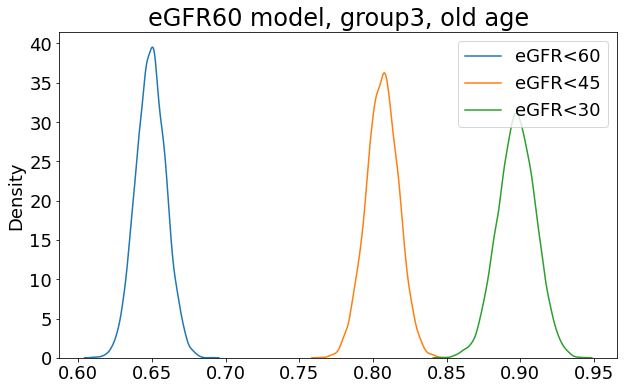

mean(ci): 0.65 (0.63-0.67), median:0.65
mean(ci): 0.81 (0.78-0.83), median:0.81
mean(ci): 0.90 (0.87-0.92), median:0.90


In [61]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(se_g3_60, label='eGFR<60') 
sns.kdeplot(se_g3_45, label='eGFR<45') 
sns.kdeplot(se_g3_30, label='eGFR<30') 
plt.title("eGFR60 model, group3, old age", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

cical(se_g3_60)
cical(se_g3_45)
cical(se_g3_30)

### group4, proteinuria

In [62]:
X_test_g4['pred'] = np.where(X_test_g4['prob']>=0.83, 1, 0)
X_test_g4['pred'].value_counts()

# 60
X_test_g460 = X_test_g4.query('eGFR_ckd<60')
X_test_g460['acc'] = X_test_g460['eGFR_ab'] == X_test_g460['pred']
print('60all: %d right: %d ratio: %.1f' % (len(X_test_g460), sum(X_test_g460['acc']), sum(X_test_g460['acc'])/len(X_test_g460)*100))

#45
X_test_g445 = X_test_g4.query('eGFR_ckd<45')
X_test_g445['eGFR_ab45'] = np.where(X_test_g445['eGFR_ckd']<45,1,0)
X_test_g445['acc'] = X_test_g445['eGFR_ab45'] == X_test_g445['pred']
print('45all: %d right: %d ratio: %.1f' % (len(X_test_g445), sum(X_test_g445['acc']), sum(X_test_g445['acc'])/len(X_test_g445)*100))

#30
X_test_g430 = X_test_g4.query('eGFR_ckd<30')
X_test_g430['eGFR_ab30'] = np.where(X_test_g430['eGFR_ckd']<30,1,0)
X_test_g430['acc'] = X_test_g430['eGFR_ab30'] == X_test_g430['pred']
print('30all: %d right: %d ratio: %.1f' % (len(X_test_g430), sum(X_test_g430['acc']), sum(X_test_g430['acc'])/len(X_test_g430)*100))

60all: 1467 right: 1185 ratio: 80.8
45all: 994 right: 846 ratio: 85.1
30all: 632 right: 543 ratio: 85.9


In [63]:
# test set
data = X_test_g460

# configure bootstrap
n_iterations = 10000
# n_size = len(data)

# run bootstrap
se_g4_60, acc = [], []
se_g4_45, acc45 = [], []
se_g4_30, acc30 = [], []

with tqdm.tqdm(total=len(data)) as pbar:
    for i in range(n_iterations):
        # 60
        boot = resample(data, n_samples=n_size, replace=True, 
                        #stratify=data['eGFR_ab']
                       )
        acc = boot['eGFR_ab'] == boot['pred']
        se = sum(acc)/len(boot)
        se_g4_60.append(se)
        
        # 45
        data45 = data.query('eGFR_ckd<45')
        boot45 = resample(data45, n_samples=len(data45), replace=True)
        boot45['eGFR_ab45'] = np.where(boot45['eGFR_ckd']<45,1,0)
        acc45 = boot45['eGFR_ab45'] == boot45['pred']
        se45 = sum(acc45)/len(boot45)
        se_g4_45.append(se45)
        
        # 30
        data30 = data.query('eGFR_ckd<30')
        boot30 = resample(data30, n_samples=len(data30), replace=True)
        boot30['eGFR_ab30'] = np.where(boot30['eGFR_ckd']<30,1,0)
        acc30 = boot30['eGFR_ab30'] == boot30['pred']
        se30 = sum(acc30)/len(boot30)
        se_g4_30.append(se30)
        
        pbar.update()

10000it [00:58, 171.96it/s]                         


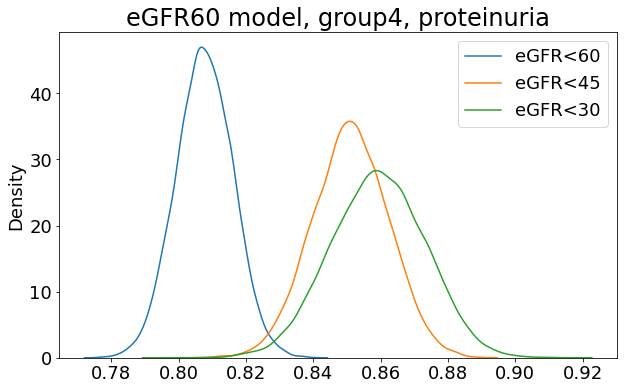

mean(ci): 0.81 (0.79-0.82), median:0.81
mean(ci): 0.85 (0.83-0.87), median:0.85
mean(ci): 0.86 (0.83-0.89), median:0.86


In [64]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(se_g4_60, label='eGFR<60') 
sns.kdeplot(se_g4_45, label='eGFR<45') 
sns.kdeplot(se_g4_30, label='eGFR<30') 
plt.title("eGFR60 model, group4, proteinuria", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

cical(se_g4_60)
cical(se_g4_45)
cical(se_g4_30)

### group5, high prevalence

In [65]:
X_test_g5['pred'] = np.where(X_test_g5['prob']>=0.90, 1, 0)
X_test_g5['pred'].value_counts()

# 60
X_test_g560 = X_test_g5.query('eGFR_ckd<60')
X_test_g560['acc'] = X_test_g560['eGFR_ab'] == X_test_g560['pred']
print('60all: %d right: %d ratio: %.1f' % (len(X_test_g560), sum(X_test_g560['acc']), sum(X_test_g560['acc'])/len(X_test_g560)*100))

#45
X_test_g545 = X_test_g5.query('eGFR_ckd<45')
X_test_g545['eGFR_ab45'] = np.where(X_test_g545['eGFR_ckd']<45,1,0)
X_test_g545['acc'] = X_test_g545['eGFR_ab45'] == X_test_g545['pred']
print('45all: %d right: %d ratio: %.1f' % (len(X_test_g545), sum(X_test_g545['acc']), sum(X_test_g545['acc'])/len(X_test_g545)*100))

#30
X_test_g530 = X_test_g5.query('eGFR_ckd<30')
X_test_g530['eGFR_ab30'] = np.where(X_test_g530['eGFR_ckd']<30,1,0)
X_test_g530['acc'] = X_test_g530['eGFR_ab30'] == X_test_g530['pred']
print('30all: %d right: %d ratio: %.1f' % (len(X_test_g530), sum(X_test_g530['acc']), sum(X_test_g530['acc'])/len(X_test_g530)*100))

60all: 895 right: 696 ratio: 77.8
45all: 573 right: 495 ratio: 86.4
30all: 343 right: 313 ratio: 91.3


In [66]:
# test set
data = X_test_g560

# configure bootstrap
n_iterations = 10000
# n_size = len(data)

# run bootstrap
se_g5_60, acc = [], []
se_g5_45, acc45 = [], []
se_g5_30, acc30 = [], []

with tqdm.tqdm(total=len(data)) as pbar:
    for i in range(n_iterations):
        # 60
        boot = resample(data, n_samples=n_size, replace=True, 
                        #stratify=data['eGFR_ab']
                       )
        acc = boot['eGFR_ab'] == boot['pred']
        se = sum(acc)/len(boot)
        se_g5_60.append(se)
        
        # 45
        data45 = data.query('eGFR_ckd<45')
        boot45 = resample(data45, n_samples=len(data45), replace=True)
        boot45['eGFR_ab45'] = np.where(boot45['eGFR_ckd']<45,1,0)
        acc45 = boot45['eGFR_ab45'] == boot45['pred']
        se45 = sum(acc45)/len(boot45)
        se_g5_45.append(se45)
        
        # 30
        data30 = data.query('eGFR_ckd<30')
        boot30 = resample(data30, n_samples=len(data30), replace=True)
        boot30['eGFR_ab30'] = np.where(boot30['eGFR_ckd']<30,1,0)
        acc30 = boot30['eGFR_ab30'] == boot30['pred']
        se30 = sum(acc30)/len(boot30)
        se_g5_30.append(se30)
        
        pbar.update()

10000it [00:55, 179.75it/s]                       


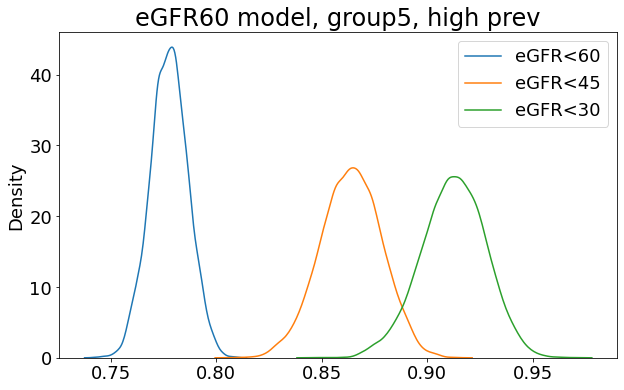

mean(ci): 0.78 (0.76-0.79), median:0.78
mean(ci): 0.86 (0.83-0.89), median:0.86
mean(ci): 0.91 (0.88-0.94), median:0.91


In [67]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(se_g5_60, label='eGFR<60') 
sns.kdeplot(se_g5_45, label='eGFR<45') 
sns.kdeplot(se_g5_30, label='eGFR<30') 
plt.title("eGFR60 model, group5, high prev", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

cical(se_g5_60)
cical(se_g5_45)
cical(se_g5_30)

In [68]:
df_se_trend = pd.DataFrame({
    'eGFR' : ['eGFR<60', 'eGFR<45', 'eGFR<30',
             'eGFR<60', 'eGFR<45', 'eGFR<30',
             'eGFR<60', 'eGFR<45', 'eGFR<30',
             'eGFR<60', 'eGFR<45', 'eGFR<30',
             'eGFR<60', 'eGFR<45', 'eGFR<30',
             'eGFR<60', 'eGFR<45', 'eGFR<30'],
    
    'se'   : [0.87, 0.93, 0.95, 
              0.77, 0.83, 0.83, 
              0.86, 1.00, 1.00, 
              0.65, 0.81, 0.90, 
              0.81, 0.85, 0.86, 
              0.78, 0.86, 0.91],
    
    'lower' : [0.86, 0.92, 0.94,
              0.76, 0.70, 0.67,
              0.85, 1.00, 1.00,
              0.64, 0.78, 0.87,
              0.80, 0.83, 0.83,
              0.77, 0.83, 0.88],
    
    'upper' : [0.88, 0.94, 0.97,
              0.78, 0.97, 1.00,
              0.87, 1.00, 1.00,
              0.66, 0.83, 0.92,
              0.82, 0.87, 0.88,
              0.79, 0.89, 0.94],
    
    'group'  : ['All', 'All', 'All',
               'Diabetes', 'Diabetes', 'Diabetes',
               'Hypertension', 'Hypertension', 'Hypertension',
               'Old age', 'Old age', 'Old age',
               'Proteinuria','Proteinuria','Proteinuria',
               'High prev','High prev','High prev']
})
df_se_trend['lower'] = df_se_trend['se'] - df_se_trend['lower']
df_se_trend['upper'] = df_se_trend['upper'] - df_se_trend['se']
df_se_trend

,eGFR,se,lower,upper,group
0,eGFR<60,0.87,0.01,0.01,All
1,eGFR<45,0.93,0.01,0.01,All
2,eGFR<30,0.95,0.01,0.02,All
3,eGFR<60,0.77,0.01,0.01,Diabetes
4,eGFR<45,0.83,0.13,0.14,Diabetes
5,eGFR<30,0.83,0.16,0.17,Diabetes
6,eGFR<60,0.86,0.01,0.01,Hypertension
7,eGFR<45,1.00,0.00,0.00,Hypertension
8,eGFR<30,1.00,0.00,0.00,Hypertension
9,eGFR<60,0.65,0.01,0.01,Old age


In [69]:
df_se_trend_sub = df_se_trend.query('group=="All"|group=="Old age"|group=="High prev"')
df_se_trend_sub

,eGFR,se,lower,upper,group
0,eGFR<60,0.87,0.01,0.01,All
1,eGFR<45,0.93,0.01,0.01,All
2,eGFR<30,0.95,0.01,0.02,All
9,eGFR<60,0.65,0.01,0.01,Old age
10,eGFR<45,0.81,0.03,0.02,Old age
11,eGFR<30,0.90,0.03,0.02,Old age
15,eGFR<60,0.78,0.01,0.01,High prev
16,eGFR<45,0.86,0.03,0.03,High prev
17,eGFR<30,0.91,0.03,0.03,High prev


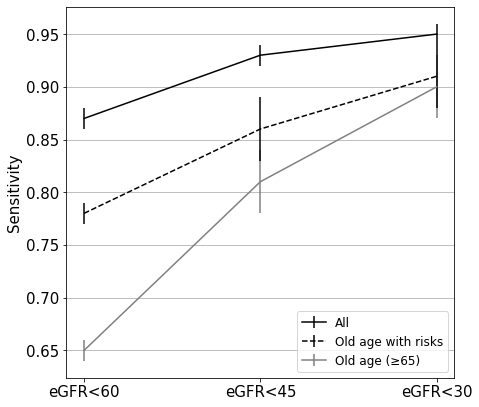

In [126]:
# trends of sensitivities plot
plt.rcParams["figure.figsize"] = (7,6)
fig,ax = plt.subplots()
#sns.set(style= "whitegrid")

df = df_se_trend_sub
lvls = df.group.unique()
#for i in lvls:
#    ax.errorbar(x = df[df['group']==i]["eGFR"],
#                y=df[df['group']==i]["se"], 
#                yerr=[df[df['group']==i]["lower"], df[df['group']==i]["lower"]],
#               label=i)
    
ax.errorbar(x = df[df['group']=='All']["eGFR"],
            y=df[df['group']=='All']["se"], 
            yerr=[df[df['group']=='All']["lower"], df[df['group']=='All']["lower"]],
            label='All', color='k', linestyle='-')

ax.errorbar(x = df[df['group']=='Old age']["eGFR"],
            y=df[df['group']=='Old age']["se"], 
            yerr=[df[df['group']=='Old age']["lower"], df[df['group']=='Old age']["lower"]],
            label='Old age (≥65)', color='grey')

ax.errorbar(x = df[df['group']=='High prev']["eGFR"],
            y=df[df['group']=='High prev']["se"], 
            yerr=[df[df['group']=='High prev']["lower"], df[df['group']=='High prev']["lower"]],
            label='Old age with risks', color='k', linestyle='--')

#ax.axhline(y=0.5 , color='k', linestyle='--')
#ax.legend(loc=4, prop={'size':12})
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_ylabel('Sensitivity', fontsize=15)

handles, labels = plt.gca().get_legend_handles_labels()
order = [0,2,1]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc=4, fontsize=12)

#plt.show()
plt.grid(axis='y')
plt.tight_layout()

#plt.savefig('/home/danssa/proj_ua/images/5sub/old_sen_internal.png', dpi=300)

# external subgroup analysis

## sub group analysis, internal : DM, HTN, old age, proteinuria

In [71]:
# subset each group
X_test_g1_ev = X_test_bs_ev.query('dm==1')
X_test_g2_ev = X_test_bs_ev.query('htn==1')
X_test_g3_ev = X_test_bs_ev.query('age>=65')
X_test_g4_ev = X_test_bs_ev.query('he_upro>1')
X_test_g5_ev = X_test_bs_ev.query('dm==1&age>=65|htn==1&age>=65|he_upro>1&age>=65')

In [72]:
print('total cases, prevalence (cases)')
print('group1: %d, %.1f (%d)' % (sum(X_test_g1_ev['wt']), sum(X_test_g1_ev.query('eGFR_ab==1')['wt'])/sum(X_test_g1_ev['wt'])*100, sum(X_test_g1_ev.query('eGFR_ab==1')['wt'])))
print('group2: %d, %.1f (%d)' % (sum(X_test_g2_ev['wt']), sum(X_test_g2_ev.query('eGFR_ab==1')['wt'])/sum(X_test_g2_ev['wt'])*100, sum(X_test_g2_ev.query('eGFR_ab==1')['wt'])))
print('group3: %d, %.1f (%d)' % (sum(X_test_g3_ev['wt']), sum(X_test_g3_ev.query('eGFR_ab==1')['wt'])/sum(X_test_g3_ev['wt'])*100, sum(X_test_g3_ev.query('eGFR_ab==1')['wt'])))
print('group4: %d, %.1f (%d)' % (sum(X_test_g4_ev['wt']), sum(X_test_g4_ev.query('eGFR_ab==1')['wt'])/sum(X_test_g4_ev['wt'])*100, sum(X_test_g4_ev.query('eGFR_ab==1')['wt'])))
print('group5: %d, %.1f (%d)' % (sum(X_test_g5_ev['wt']), sum(X_test_g5_ev.query('eGFR_ab==1')['wt'])/sum(X_test_g5_ev['wt'])*100, sum(X_test_g5_ev.query('eGFR_ab==1')['wt'])))

total cases, prevalence (cases)
group1: 1885164, 11.5 (216169)
group2: 4903960, 8.8 (430602)
group3: 4499556, 11.3 (508470)
group4: 564442, 17.8 (100487)
group5: 2371298, 15.3 (363555)


## sub1 : DM

In [73]:
# test set
data = X_test_g1_ev

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_s1_ev = []
th_box_s1_ev = []
se_box_s1_ev = []
sp_box_s1_ev = []

with tqdm.tqdm(total=len(data)) as pbar:
    for i in range(n_iterations):
        boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab'])
        auc = roc_auc_score(boot['eGFR_ab'], boot['prob'], sample_weight=boot['wt'])
    
        auc_box_s1_ev.append(auc)
    
        # calculate roc curves
        fpr, tpr, thresholds = roc_curve(boot['eGFR_ab'], boot['prob'], sample_weight=boot['wt'])
        J = tpr - fpr
        ix = argmax(J)
        best_thresh, se, sp = thresholds[ix], tpr[ix], 1-fpr[ix]
    
        th_box_s1_ev.append(best_thresh)
        se_box_s1_ev.append(se)
        sp_box_s1_ev.append(sp)
    
        pbar.update()

10000it [00:46, 213.01it/s]                         


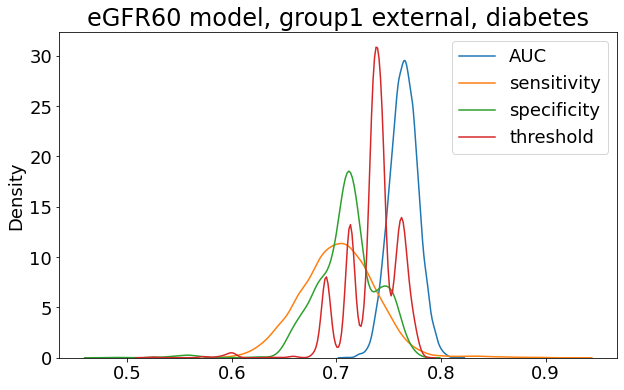

mean(ci): 0.76 (0.74-0.79), median:0.76
mean(ci): 0.70 (0.63-0.77), median:0.70
mean(ci): 0.71 (0.65-0.76), median:0.71
mean(ci): 0.73 (0.69-0.77), median:0.74


In [74]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(auc_box_s1_ev, label='AUC') 
sns.kdeplot(se_box_s1_ev, label='sensitivity')
sns.kdeplot(sp_box_s1_ev, label='specificity')
sns.kdeplot(th_box_s1_ev, label='threshold')
plt.title("eGFR60 model, group1 external, diabetes", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

cical(auc_box_s1_ev)
cical(se_box_s1_ev)
cical(sp_box_s1_ev)
cical(th_box_s1_ev)

In [75]:
#Youden’s J statistic. / J = Sensitivity + Specificity – 1
y_prob = X_test_g1_ev['prob']
y_test = X_test_g1_ev['eGFR_ab']
weight = X_test_g1_ev['wt']

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_prob, sample_weight=weight)
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('eGFR60 model, group1 external')
print('AUC         : %.2f\nsensitivity : %.2f\nspecificity : %.2f\nThreshold   : %.2f' 
      % (roc_auc_score(y_test, y_prob, sample_weight=weight), tpr[ix], 1-fpr[ix], best_thresh))

print('\nClassification Report\n')
y_prob_pred = (y_prob >= best_thresh).astype(bool)
print(classification_report(y_test, y_prob_pred, target_names=['normal', 'abnormal'], sample_weight=weight))

eGFR60 model, group1 external
AUC         : 0.76
sensitivity : 0.70
specificity : 0.71
Threshold   : 0.74

Classification Report

              precision    recall  f1-score   support

      normal       0.95      0.71      0.81 1668995.4324709862
    abnormal       0.24      0.70      0.35 216169.055504264

    accuracy                           0.71 1885164.4879752502
   macro avg       0.59      0.70      0.58 1885164.4879752502
weighted avg       0.87      0.71      0.76 1885164.4879752502



In [76]:
# test set
data = X_test_g2_ev

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_s2_ev = []
th_box_s2_ev = []
se_box_s2_ev = []
sp_box_s2_ev = []

with tqdm.tqdm(total=n_iterations) as pbar:
    for i in range(n_iterations):
        boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab'])
        auc = roc_auc_score(boot['eGFR_ab'], boot['prob'], sample_weight=boot['wt'])
    
        auc_box_s2_ev.append(auc)
    
        # calculate roc curves
        fpr, tpr, thresholds = roc_curve(boot['eGFR_ab'], boot['prob'], sample_weight=boot['wt'])
        J = tpr - fpr
        ix = argmax(J)
        best_thresh, se, sp = thresholds[ix], tpr[ix], 1-fpr[ix]
    
        th_box_s2_ev.append(best_thresh)
        se_box_s2_ev.append(se)
        sp_box_s2_ev.append(sp)
    
        pbar.update()

100%|██████████| 10000/10000 [01:31<00:00, 109.49it/s]


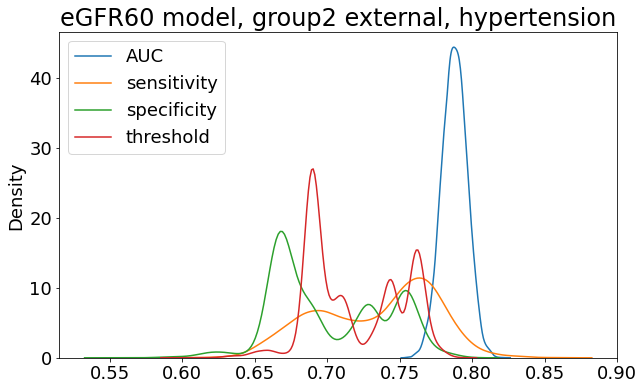

mean(ci): 0.79 (0.77-0.80), median:0.79
mean(ci): 0.73 (0.66-0.80), median:0.74
mean(ci): 0.70 (0.64-0.77), median:0.69
mean(ci): 0.72 (0.66-0.77), median:0.71


In [77]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(auc_box_s2_ev, label='AUC') 
sns.kdeplot(se_box_s2_ev, label='sensitivity')
sns.kdeplot(sp_box_s2_ev, label='specificity')
sns.kdeplot(th_box_s2_ev, label='threshold')
plt.title("eGFR60 model, group2 external, hypertension", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

cical(auc_box_s2_ev)
cical(se_box_s2_ev)
cical(sp_box_s2_ev)
cical(th_box_s2_ev)

In [78]:
#Youden’s J statistic. / J = Sensitivity + Specificity – 1
y_prob = X_test_g2_ev['prob']
y_test = X_test_g2_ev['eGFR_ab']
weight = X_test_g2_ev['wt']

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_prob, sample_weight=weight)
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('eGFR60 model, group2 external')
print('AUC         : %.2f\nsensitivity : %.2f\nspecificity : %.2f\nThreshold   : %.2f' 
      % (roc_auc_score(y_test, y_prob, sample_weight=weight), tpr[ix], 1-fpr[ix], best_thresh))

print('\nClassification Report\n')
y_prob_pred = (y_prob >= best_thresh).astype(bool)
print(classification_report(y_test, y_prob_pred, target_names=['normal', 'abnormal'], sample_weight=weight))

eGFR60 model, group2 external
AUC         : 0.79
sensitivity : 0.76
specificity : 0.67
Threshold   : 0.69

Classification Report

              precision    recall  f1-score   support

      normal       0.97      0.67      0.79 4473358.477367811
    abnormal       0.18      0.76      0.29 430602.31865963247

    accuracy                           0.67 4903960.796027443
   macro avg       0.57      0.72      0.54 4903960.796027443
weighted avg       0.90      0.67      0.75 4903960.796027443



In [79]:
# test set
data = X_test_g3_ev

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_s3_ev = []
th_box_s3_ev = []
se_box_s3_ev = []
sp_box_s3_ev = []

with tqdm.tqdm(total=n_iterations) as pbar:
    for i in range(n_iterations):
        boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab'])
        auc = roc_auc_score(boot['eGFR_ab'], boot['prob'], sample_weight=boot['wt'])
        
        auc_box_s3_ev.append(auc)
        
        # calculate roc curves
        fpr, tpr, thresholds = roc_curve(boot['eGFR_ab'], boot['prob'], sample_weight=boot['wt'])
        J = tpr - fpr
        ix = argmax(J)
        best_thresh, se, sp = thresholds[ix], tpr[ix], 1-fpr[ix]
        
        th_box_s3_ev.append(best_thresh)
        se_box_s3_ev.append(se)
        sp_box_s3_ev.append(sp)
        
        pbar.update()

100%|██████████| 10000/10000 [01:42<00:00, 97.31it/s]


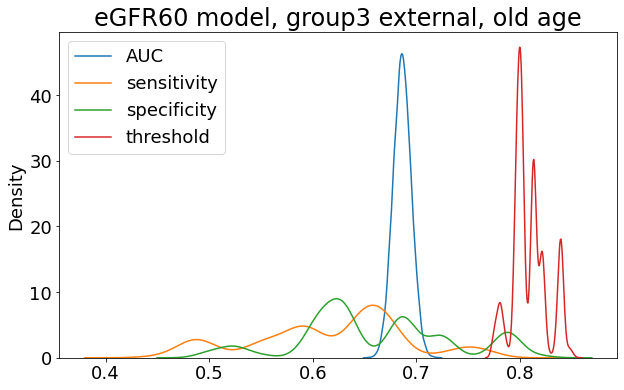

mean(ci): 0.69 (0.67-0.70), median:0.69
mean(ci): 0.62 (0.47-0.76), median:0.63
mean(ci): 0.66 (0.51-0.80), median:0.64
mean(ci): 0.81 (0.78-0.84), median:0.80


In [80]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(auc_box_s3_ev, label='AUC') 
sns.kdeplot(se_box_s3_ev, label='sensitivity')
sns.kdeplot(sp_box_s3_ev, label='specificity')
sns.kdeplot(th_box_s3_ev, label='threshold')
plt.title("eGFR60 model, group3 external, old age", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

cical(auc_box_s3_ev)
cical(se_box_s3_ev)
cical(sp_box_s3_ev)
cical(th_box_s3_ev)

In [81]:
#Youden’s J statistic. / J = Sensitivity + Specificity – 1
y_prob = X_test_g3_ev['prob']
y_test = X_test_g3_ev['eGFR_ab']
weight = X_test_g3_ev['wt']

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_prob, sample_weight=weight)
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('eGFR60 model, group3 external')
print('AUC         : %.2f\nsensitivity : %.2f\nspecificity : %.2f\nThreshold   : %.2f' 
      % (roc_auc_score(y_test, y_prob, sample_weight=weight), tpr[ix], 1-fpr[ix], best_thresh))

print('\nClassification Report\n')
y_prob_pred = (y_prob >= best_thresh).astype(bool)
print(classification_report(y_test, y_prob_pred, target_names=['normal', 'abnormal'], sample_weight=weight))

eGFR60 model, group3 external
AUC         : 0.69
sensitivity : 0.65
specificity : 0.63
Threshold   : 0.80

Classification Report

              precision    recall  f1-score   support

      normal       0.93      0.63      0.75 3991086.0324062016
    abnormal       0.18      0.65      0.28 508470.5530124808

    accuracy                           0.63 4499556.585418683
   macro avg       0.56      0.64      0.52 4499556.585418683
weighted avg       0.85      0.63      0.70 4499556.585418683



In [82]:
# test set
data = X_test_g4_ev

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_s4_ev = []
th_box_s4_ev = []
se_box_s4_ev = []
sp_box_s4_ev = []

with tqdm.tqdm(total=n_iterations) as pbar:
    for i in range(n_iterations):
        boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab'])
        auc = roc_auc_score(boot['eGFR_ab'], boot['prob'], sample_weight=boot['wt'])
        
        auc_box_s4_ev.append(auc)
        
        # calculate roc curves
        fpr, tpr, thresholds = roc_curve(boot['eGFR_ab'], boot['prob'], sample_weight=boot['wt'])
        J = tpr - fpr
        ix = argmax(J)
        best_thresh, se, sp = thresholds[ix], tpr[ix], 1-fpr[ix]
        
        th_box_s4_ev.append(best_thresh)
        se_box_s4_ev.append(se)
        sp_box_s4_ev.append(sp)
        
        pbar.update()

100%|██████████| 10000/10000 [00:26<00:00, 371.33it/s]


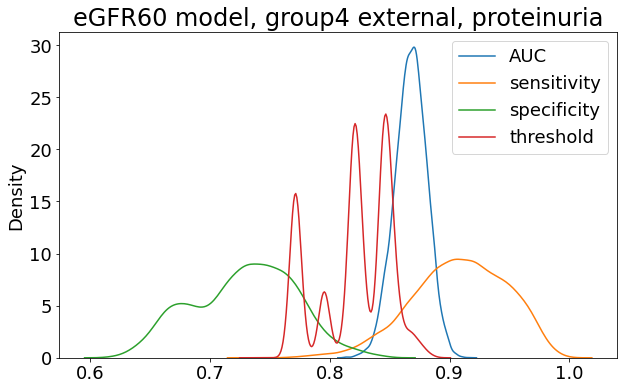

mean(ci): 0.87 (0.84-0.89), median:0.87
mean(ci): 0.91 (0.83-0.97), median:0.91
mean(ci): 0.73 (0.65-0.81), median:0.73
mean(ci): 0.82 (0.77-0.87), median:0.82


In [83]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(auc_box_s4_ev, label='AUC') 
sns.kdeplot(se_box_s4_ev, label='sensitivity')
sns.kdeplot(sp_box_s4_ev, label='specificity')
sns.kdeplot(th_box_s4_ev, label='threshold')
plt.title("eGFR60 model, group4 external, proteinuria", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

cical(auc_box_s4_ev)
cical(se_box_s4_ev)
cical(sp_box_s4_ev)
cical(th_box_s4_ev)

In [84]:
#Youden’s J statistic. / J = Sensitivity + Specificity – 1
y_prob = X_test_g4_ev['prob']
y_test = X_test_g4_ev['eGFR_ab']
weight = X_test_g4_ev['wt']

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_prob, sample_weight=weight)
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('eGFR60 model, group4 external')
print('AUC         : %.2f\nsensitivity : %.2f\nspecificity : %.2f\nThreshold   : %.2f' 
      % (roc_auc_score(y_test, y_prob, sample_weight=weight), tpr[ix], 1-fpr[ix], best_thresh))

print('\nClassification Report\n')
y_prob_pred = (y_prob >= best_thresh).astype(bool)
print(classification_report(y_test, y_prob_pred, target_names=['normal', 'abnormal'], sample_weight=weight))

eGFR60 model, group4 external
AUC         : 0.87
sensitivity : 0.90
specificity : 0.73
Threshold   : 0.82

Classification Report

              precision    recall  f1-score   support

      normal       0.97      0.73      0.83 463954.7993251281
    abnormal       0.42      0.90      0.57 100487.4241931813

    accuracy                           0.76 564442.2235183094
   macro avg       0.69      0.81      0.70 564442.2235183094
weighted avg       0.87      0.76      0.78 564442.2235183094



In [85]:
# test set
data = X_test_g5_ev

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_s5_ev = []
th_box_s5_ev = []
se_box_s5_ev = []
sp_box_s5_ev = []

with tqdm.tqdm(total=n_iterations) as pbar:
    for i in range(n_iterations):
        boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab'])
        auc = roc_auc_score(boot['eGFR_ab'], boot['prob'], sample_weight=boot['wt'])
        
        auc_box_s5_ev.append(auc)
        
        # calculate roc curves
        fpr, tpr, thresholds = roc_curve(boot['eGFR_ab'], boot['prob'], sample_weight=boot['wt'])
        J = tpr - fpr
        ix = argmax(J)
        best_thresh, se, sp = thresholds[ix], tpr[ix], 1-fpr[ix]
        
        th_box_s5_ev.append(best_thresh)
        se_box_s5_ev.append(se)
        sp_box_s5_ev.append(sp)
        
        pbar.update()

100%|██████████| 10000/10000 [01:03<00:00, 158.24it/s]


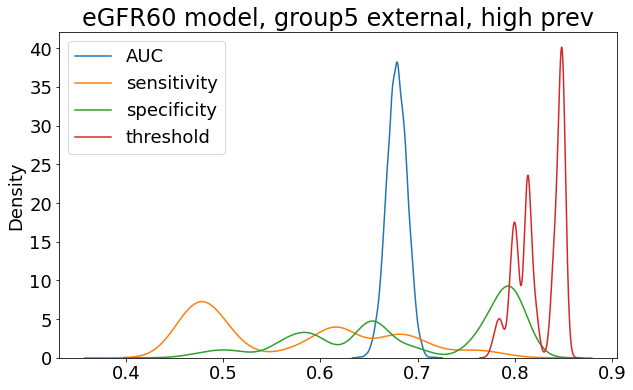

mean(ci): 0.68 (0.66-0.70), median:0.68
mean(ci): 0.57 (0.45-0.77), median:0.57
mean(ci): 0.70 (0.49-0.81), median:0.70
mean(ci): 0.82 (0.78-0.85), median:0.82


In [86]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(auc_box_s5_ev, label='AUC') 
sns.kdeplot(se_box_s5_ev, label='sensitivity')
sns.kdeplot(sp_box_s5_ev, label='specificity')
sns.kdeplot(th_box_s5_ev, label='threshold')
plt.title("eGFR60 model, group5 external, high prev", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

cical(auc_box_s5_ev)
cical(se_box_s5_ev)
cical(sp_box_s5_ev)
cical(th_box_s5_ev)

In [87]:
#Youden’s J statistic. / J = Sensitivity + Specificity – 1
y_prob = X_test_g5_ev['prob']
y_test = X_test_g5_ev['eGFR_ab']
weight = X_test_g5_ev['wt']

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_prob, sample_weight=weight)
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('eGFR60 model, group5 external')
print('AUC         : %.2f\nsensitivity : %.2f\nspecificity : %.2f\nThreshold   : %.2f' 
      % (roc_auc_score(y_test, y_prob, sample_weight=weight), tpr[ix], 1-fpr[ix], best_thresh))

print('\nClassification Report\n')
y_prob_pred = (y_prob >= best_thresh).astype(bool)
print(classification_report(y_test, y_prob_pred, target_names=['normal', 'abnormal'], sample_weight=weight))

eGFR60 model, group5 external
AUC         : 0.68
sensitivity : 0.47
specificity : 0.79
Threshold   : 0.85

Classification Report

              precision    recall  f1-score   support

      normal       0.89      0.79      0.84 2007742.8485482105
    abnormal       0.29      0.47      0.36 363555.2107512609

    accuracy                           0.74 2371298.0592994713
   macro avg       0.59      0.63      0.60 2371298.0592994713
weighted avg       0.80      0.74      0.77 2371298.0592994713



## accuracy in eGFR<60, eGFR<45 and eGFR<30

### external

### all

In [88]:
X_test_bs_ev['pred'] = np.where(X_test_bs_ev['prob']>=0.48, 1, 0)
X_test_bs_ev['pred'].value_counts()

print('external validation')
#60
X_test_bs_60_ev = X_test_bs_ev.query('eGFR_ckd<60')
X_test_bs_60_ev['acc'] = X_test_bs_60_ev['eGFR_ab'] == X_test_bs_60_ev['pred']
print('60all: %.f right: %.f ratio: %.1f' % 
      (sum(X_test_bs_60_ev['wt']), sum(X_test_bs_60_ev.query('acc==1')['wt']), sum(X_test_bs_60_ev.query('acc==1')['wt'])/sum(X_test_bs_60_ev['wt'])*100))

#45
X_test_bs_45_ev = X_test_bs_ev.query('eGFR_ckd<45')
X_test_bs_45_ev['eGFR_ab45'] = np.where(X_test_bs_45_ev['eGFR_ckd']<45,1,0)
X_test_bs_45_ev['acc'] = X_test_bs_45_ev['eGFR_ab'] == X_test_bs_45_ev['pred']
print('45all: %.f right: %.f ratio: %.1f' % 
      (sum(X_test_bs_45_ev['wt']), sum(X_test_bs_45_ev.query('acc==1')['wt']), sum(X_test_bs_45_ev.query('acc==1')['wt'])/sum(X_test_bs_45_ev['wt'])*100))

#30
X_test_bs_30_ev = X_test_bs_ev.query('eGFR_ckd<30')
X_test_bs_30_ev['eGFR_ab30'] = np.where(X_test_bs_30_ev['eGFR_ckd']<30,1,0)
X_test_bs_30_ev['acc'] = X_test_bs_30_ev['eGFR_ab'] == X_test_bs_30_ev['pred']
print('30all: %.f right: %.f ratio: %.1f' % 
      (sum(X_test_bs_30_ev['wt']), sum(X_test_bs_30_ev.query('acc==1')['wt']), sum(X_test_bs_30_ev.query('acc==1')['wt'])/sum(X_test_bs_30_ev['wt'])*100))

external validation
60all: 726038 right: 638047 ratio: 87.9
45all: 170449 right: 155414 ratio: 91.2
30all: 55485 right: 49078 ratio: 88.5


In [89]:
# test set
data = X_test_bs_60_ev

# configure bootstrap
n_iterations = 10000
#n_size = len(data)

# run bootstrap
se_all_60_ev = []
se_all_45_ev = []
se_all_30_ev = []

with tqdm.tqdm(total=len(data)) as pbar:
    for i in range(n_iterations):
        # 60
        boot = resample(data, n_samples=len(data), replace=True, 
                        #stratify=data['eGFR_ab']
                       )
        boot['acc'] = boot['eGFR_ab'] == boot['pred']
        se = sum(boot.query('acc==1')['wt'])/sum(boot['wt'])
        se_all_60_ev.append(se)
        
        # 45
        data45 = data.query('eGFR_ckd<45')
        boot45 = resample(data45, n_samples=len(data45), replace=True)
        boot45['eGFR_ab45'] = np.where(boot45['eGFR_ckd']<45,1,0)
        boot45['acc45'] = boot45['eGFR_ab45'] == boot45['pred']
        se45 = sum(boot45.query('acc45==1')['wt'])/sum(boot45['wt'])
        se_all_45_ev.append(se45)
        
        # 30
        data30 = data.query('eGFR_ckd<30')
        boot30 = resample(data30, n_samples=len(data30), replace=True)
        boot30['eGFR_ab30'] = np.where(boot30['eGFR_ckd']<30,1,0)
        boot30['acc30'] = boot30['eGFR_ab30'] == boot30['pred']
        se30 = sum(boot30.query('acc30==1')['wt'])/sum(boot30['wt'])
        se_all_30_ev.append(se30)
        
        pbar.update()

10000it [02:05, 79.80it/s]                         


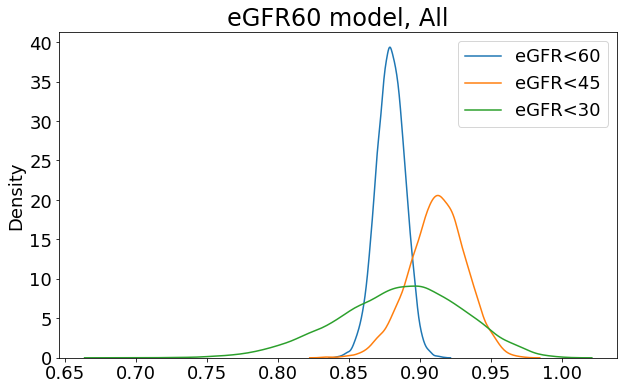

mean(ci): 0.88 (0.86-0.90), median:0.88
mean(ci): 0.91 (0.87-0.95), median:0.91
mean(ci): 0.89 (0.79-0.96), median:0.89


In [90]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(se_all_60_ev, label='eGFR<60') 
sns.kdeplot(se_all_45_ev, label='eGFR<45') 
sns.kdeplot(se_all_30_ev, label='eGFR<30') 
plt.title("eGFR60 model, All", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

cical(se_all_60_ev)
cical(se_all_45_ev)
cical(se_all_30_ev)

### group1, diabetes

In [91]:
X_test_g1_ev['pred'] = np.where(X_test_g1_ev['prob']>=0.68, 1, 0)
X_test_g1_ev['pred'].value_counts()

print('external validation')
#60
X_test_g1_60_ev = X_test_g1_ev.query('eGFR_ckd<60')
X_test_g1_60_ev['acc'] = X_test_g1_60_ev['eGFR_ab'] == X_test_g1_60_ev['pred']
print('60all: %.f right: %.f ratio: %.1f' % 
      (sum(X_test_g1_60_ev['wt']), sum(X_test_g1_60_ev.query('acc==1')['wt']), sum(X_test_g1_60_ev.query('acc==1')['wt'])/sum(X_test_g1_60_ev['wt'])*100))

#45
X_test_g1_45_ev = X_test_g1_ev.query('eGFR_ckd<45')
X_test_g1_45_ev['eGFR_ab45'] = np.where(X_test_g1_45_ev['eGFR_ckd']<45,1,0)
X_test_g1_45_ev['acc'] = X_test_g1_45_ev['eGFR_ab'] == X_test_g1_45_ev['pred']
print('45all: %.f right: %.f ratio: %.1f' % 
      (sum(X_test_g1_45_ev['wt']), sum(X_test_g1_45_ev.query('acc==1')['wt']), sum(X_test_g1_45_ev.query('acc==1')['wt'])/sum(X_test_g1_45_ev['wt'])*100))

#30
X_test_g1_30_ev = X_test_g1_ev.query('eGFR_ckd<30')
X_test_g1_30_ev['eGFR_ab30'] = np.where(X_test_g1_30_ev['eGFR_ckd']<30,1,0)
X_test_g1_30_ev['acc'] = X_test_g1_30_ev['eGFR_ab'] == X_test_g1_30_ev['pred']
print('30all: %.f right: %.f ratio: %.1f' % 
      (sum(X_test_g1_30_ev['wt']), sum(X_test_g1_30_ev.query('acc==1')['wt']), sum(X_test_g1_30_ev.query('acc==1')['wt'])/sum(X_test_g1_30_ev['wt'])*100))

external validation
60all: 216169 right: 160417 ratio: 74.2
45all: 64782 right: 52610 ratio: 81.2
30all: 23325 right: 19065 ratio: 81.7


In [92]:
# test set
data = X_test_g1_ev

# configure bootstrap
n_iterations = 10000
#n_size = len(data)

# run bootstrap
se_g1_60_ev = []
se_g1_45_ev = []
se_g1_30_ev = []

with tqdm.tqdm(total=n_iterations) as pbar:
    for i in range(n_iterations):
        # 60
        boot = resample(data, n_samples=len(data), replace=True, 
                        #stratify=data['eGFR_ab']
                       )
        boot['acc'] = boot['eGFR_ab'] == boot['pred']
        se = sum(boot.query('acc==1')['wt'])/sum(boot['wt'])
        se_g1_60_ev.append(se)
        
        # 45
        data45 = data.query('eGFR_ckd<45')
        boot45 = resample(data45, n_samples=len(data45), replace=True)
        boot45['eGFR_ab45'] = np.where(boot45['eGFR_ckd']<45,1,0)
        boot45['acc45'] = boot45['eGFR_ab45'] == boot45['pred']
        se45 = sum(boot45.query('acc45==1')['wt'])/sum(boot45['wt'])
        se_g1_45_ev.append(se45)
        
        # 30
        data30 = data.query('eGFR_ckd<30')
        boot30 = resample(data30, n_samples=len(data30), replace=True)
        boot30['eGFR_ab30'] = np.where(boot30['eGFR_ckd']<30,1,0)
        boot30['acc30'] = boot30['eGFR_ab30'] == boot30['pred']
        se30 = sum(boot30.query('acc30==1')['wt'])/sum(boot30['wt'])
        se_g1_30_ev.append(se30)
        
        pbar.update()

100%|██████████| 10000/10000 [02:07<00:00, 78.38it/s]


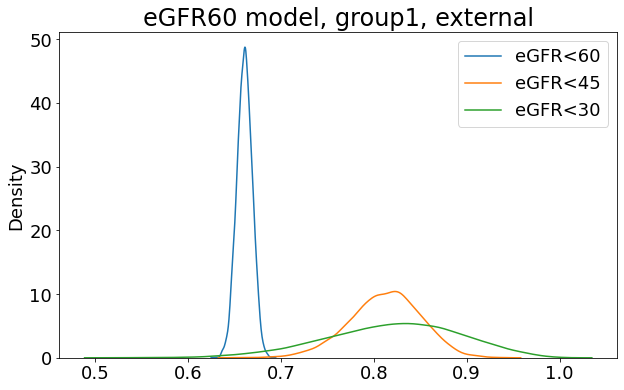

mean(ci): 0.66 (0.64-0.68), median:0.66
mean(ci): 0.81 (0.73-0.88), median:0.81
mean(ci): 0.82 (0.67-0.95), median:0.82


In [93]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(se_g1_60_ev, label='eGFR<60') 
sns.kdeplot(se_g1_45_ev, label='eGFR<45') 
sns.kdeplot(se_g1_30_ev, label='eGFR<30') 
plt.title("eGFR60 model, group1, external", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

cical(se_g1_60_ev)
cical(se_g1_45_ev)
cical(se_g1_30_ev)

### group2, hypertension

In [94]:
X_test_g2_ev['pred'] = np.where(X_test_g2_ev['prob']>=0.64, 1, 0)
X_test_g2_ev['pred'].value_counts()

print('external validation')
#60
X_test_g2_60_ev = X_test_g2_ev.query('eGFR_ckd<60')
X_test_g2_60_ev['acc'] = X_test_g2_60_ev['eGFR_ab'] == X_test_g2_60_ev['pred']
print('60all: %.f right: %.f ratio: %.1f' % 
      (sum(X_test_g2_60_ev['wt']), sum(X_test_g2_60_ev.query('acc==1')['wt']), sum(X_test_g2_60_ev.query('acc==1')['wt'])/sum(X_test_g2_60_ev['wt'])*100))

#45
X_test_g2_45_ev = X_test_g2_ev.query('eGFR_ckd<45')
X_test_g2_45_ev['eGFR_ab45'] = np.where(X_test_g2_45_ev['eGFR_ckd']<45,1,0)
X_test_g2_45_ev['acc'] = X_test_g2_45_ev['eGFR_ab'] == X_test_g2_45_ev['pred']
print('45all: %.f right: %.f ratio: %.1f' % 
      (sum(X_test_g2_45_ev['wt']), sum(X_test_g2_45_ev.query('acc==1')['wt']), sum(X_test_g2_45_ev.query('acc==1')['wt'])/sum(X_test_g2_45_ev['wt'])*100))

#30
X_test_g2_30_ev = X_test_g2_ev.query('eGFR_ckd<30')
X_test_g2_30_ev['eGFR_ab30'] = np.where(X_test_g2_30_ev['eGFR_ckd']<30,1,0)
X_test_g2_30_ev['acc'] = X_test_g2_30_ev['eGFR_ab'] == X_test_g2_30_ev['pred']
print('30all: %.f right: %.f ratio: %.1f' % 
      (sum(X_test_g2_30_ev['wt']), sum(X_test_g2_30_ev.query('acc==1')['wt']), sum(X_test_g2_30_ev.query('acc==1')['wt'])/sum(X_test_g2_30_ev['wt'])*100))

external validation
60all: 430602 right: 347590 ratio: 80.7
45all: 114951 right: 96797 ratio: 84.2
30all: 41893 right: 33376 ratio: 79.7


In [95]:
# test set
data = X_test_g2_ev

# configure bootstrap
n_iterations = 10000
#n_size = len(data)

# run bootstrap
se_g2_60_ev = []
se_g2_45_ev = []
se_g2_30_ev = []

with tqdm.tqdm(total=n_iterations) as pbar:
    for i in range(n_iterations):
        # 60
        boot = resample(data, n_samples=len(data), replace=True, 
                        #stratify=data['eGFR_ab']
                       )
        boot['acc'] = boot['eGFR_ab'] == boot['pred']
        se = sum(boot.query('acc==1')['wt'])/sum(boot['wt'])
        se_g2_60_ev.append(se)
        
        # 45
        data45 = data.query('eGFR_ckd<45')
        boot45 = resample(data45, n_samples=len(data45), replace=True)
        boot45['eGFR_ab45'] = np.where(boot45['eGFR_ckd']<45,1,0)
        boot45['acc45'] = boot45['eGFR_ab45'] == boot45['pred']
        se45 = sum(boot45.query('acc45==1')['wt'])/sum(boot45['wt'])
        se_g2_45_ev.append(se45)
        
        # 30
        data30 = data.query('eGFR_ckd<30')
        boot30 = resample(data30, n_samples=len(data30), replace=True)
        boot30['eGFR_ab30'] = np.where(boot30['eGFR_ckd']<30,1,0)
        boot30['acc30'] = boot30['eGFR_ab30'] == boot30['pred']
        se30 = sum(boot30.query('acc30==1')['wt'])/sum(boot30['wt'])
        se_g2_30_ev.append(se30)
        
        pbar.update()

100%|██████████| 10000/10000 [02:28<00:00, 67.32it/s]


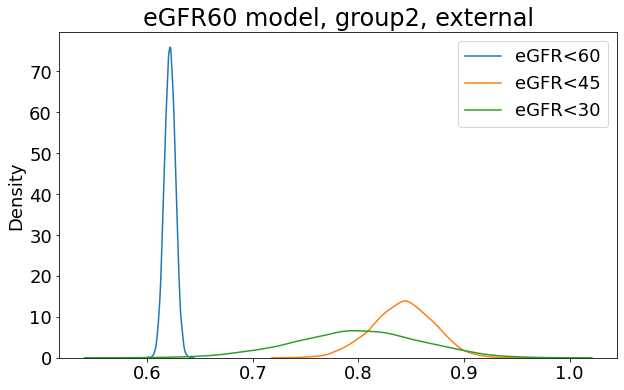

mean(ci): 0.62 (0.61-0.63), median:0.62
mean(ci): 0.84 (0.78-0.90), median:0.84
mean(ci): 0.80 (0.68-0.91), median:0.80


In [96]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(se_g2_60_ev, label='eGFR<60') 
sns.kdeplot(se_g2_45_ev, label='eGFR<45') 
sns.kdeplot(se_g2_30_ev, label='eGFR<30') 
plt.title("eGFR60 model, group2, external", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

cical(se_g2_60_ev)
cical(se_g2_45_ev)
cical(se_g2_30_ev)

### group3, old age >= 65

In [97]:
X_test_g3_ev['pred'] = np.where(X_test_g3_ev['prob']>=0.81, 1, 0)
X_test_g3_ev['pred'].value_counts()

print('external validation')
#60
X_test_g3_60_ev = X_test_g3_ev.query('eGFR_ckd<60')
X_test_g3_60_ev['acc'] = X_test_g3_60_ev['eGFR_ab'] == X_test_g3_60_ev['pred']
print('60all: %.f right: %.f ratio: %.1f' % 
      (sum(X_test_g3_60_ev['wt']), sum(X_test_g3_60_ev.query('acc==1')['wt']), sum(X_test_g3_60_ev.query('acc==1')['wt'])/sum(X_test_g3_60_ev['wt'])*100))

#45
X_test_g3_45_ev = X_test_g3_ev.query('eGFR_ckd<45')
X_test_g3_45_ev['eGFR_ab45'] = np.where(X_test_g3_45_ev['eGFR_ckd']<45,1,0)
X_test_g3_45_ev['acc'] = X_test_g3_45_ev['eGFR_ab'] == X_test_g3_45_ev['pred']
print('45all: %.f right: %.f ratio: %.1f' % 
      (sum(X_test_g3_45_ev['wt']), sum(X_test_g3_45_ev.query('acc==1')['wt']), sum(X_test_g3_45_ev.query('acc==1')['wt'])/sum(X_test_g3_45_ev['wt'])*100))

#30
X_test_g3_30_ev = X_test_g3_ev.query('eGFR_ckd<30')
X_test_g3_30_ev['eGFR_ab30'] = np.where(X_test_g3_30_ev['eGFR_ckd']<30,1,0)
X_test_g3_30_ev['acc'] = X_test_g3_30_ev['eGFR_ab'] == X_test_g3_30_ev['pred']
print('30all: %.f right: %.f ratio: %.1f' % 
      (sum(X_test_g3_30_ev['wt']), sum(X_test_g3_30_ev.query('acc==1')['wt']), sum(X_test_g3_30_ev.query('acc==1')['wt'])/sum(X_test_g3_30_ev['wt'])*100))

external validation
60all: 508471 right: 301984 ratio: 59.4
45all: 112748 right: 79784 ratio: 70.8
30all: 24062 right: 19545 ratio: 81.2


In [98]:
# test set
data = X_test_g3_ev

# configure bootstrap
n_iterations = 10000
#n_size = len(data)

# run bootstrap
se_g3_60_ev = []
se_g3_45_ev = []
se_g3_30_ev = []

with tqdm.tqdm(total=n_iterations) as pbar:
    for i in range(n_iterations):
        # 60
        boot = resample(data, n_samples=len(data), replace=True, 
                        #stratify=data['eGFR_ab']
                       )
        boot['acc'] = boot['eGFR_ab'] == boot['pred']
        se = sum(boot.query('acc==1')['wt'])/sum(boot['wt'])
        se_g3_60_ev.append(se)
        
        # 45
        data45 = data.query('eGFR_ckd<45')
        boot45 = resample(data45, n_samples=len(data45), replace=True)
        boot45['eGFR_ab45'] = np.where(boot45['eGFR_ckd']<45,1,0)
        boot45['acc45'] = boot45['eGFR_ab45'] == boot45['pred']
        se45 = sum(boot45.query('acc45==1')['wt'])/sum(boot45['wt'])
        se_g3_45_ev.append(se45)
        
        # 30
        data30 = data.query('eGFR_ckd<30')
        boot30 = resample(data30, n_samples=len(data30), replace=True)
        boot30['eGFR_ab30'] = np.where(boot30['eGFR_ckd']<30,1,0)
        boot30['acc30'] = boot30['eGFR_ab30'] == boot30['pred']
        se30 = sum(boot30.query('acc30==1')['wt'])/sum(boot30['wt'])
        se_g3_30_ev.append(se30)
        
        pbar.update()

100%|██████████| 10000/10000 [02:35<00:00, 64.40it/s]


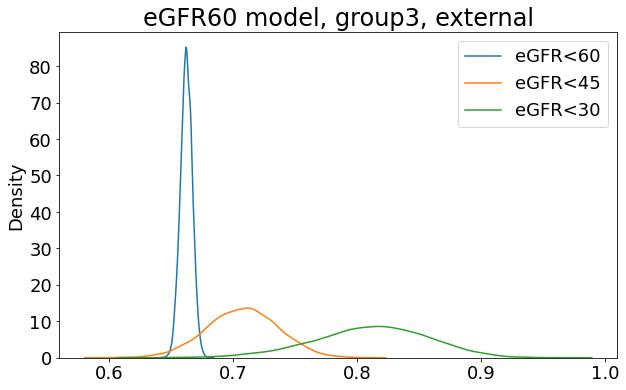

mean(ci): 0.66 (0.65-0.67), median:0.66
mean(ci): 0.71 (0.65-0.76), median:0.71
mean(ci): 0.81 (0.71-0.90), median:0.81


In [99]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(se_g3_60_ev, label='eGFR<60') 
sns.kdeplot(se_g3_45_ev, label='eGFR<45') 
sns.kdeplot(se_g3_30_ev, label='eGFR<30') 
plt.title("eGFR60 model, group3, external", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

cical(se_g3_60_ev)
cical(se_g3_45_ev)
cical(se_g3_30_ev)

### group4, proteinuria

In [100]:
X_test_g4_ev['pred'] = np.where(X_test_g4_ev['prob']>=0.82, 1, 0)
X_test_g4_ev['pred'].value_counts()

print('external validation')
#60
X_test_g4_60_ev = X_test_g4_ev.query('eGFR_ckd<60')
X_test_g4_60_ev['acc'] = X_test_g4_60_ev['eGFR_ab'] == X_test_g4_60_ev['pred']
print('60all: %.f right: %.f ratio: %.1f' % 
      (sum(X_test_g4_60_ev['wt']), sum(X_test_g4_60_ev.query('acc==1')['wt']), sum(X_test_g4_60_ev.query('acc==1')['wt'])/sum(X_test_g4_60_ev['wt'])*100))

#45
X_test_g4_45_ev = X_test_g4_ev.query('eGFR_ckd<45')
X_test_g4_45_ev['eGFR_ab45'] = np.where(X_test_g4_45_ev['eGFR_ckd']<45,1,0)
X_test_g4_45_ev['acc'] = X_test_g4_45_ev['eGFR_ab'] == X_test_g4_45_ev['pred']
print('45all: %.f right: %.f ratio: %.1f' % 
      (sum(X_test_g4_45_ev['wt']), sum(X_test_g4_45_ev.query('acc==1')['wt']), sum(X_test_g4_45_ev.query('acc==1')['wt'])/sum(X_test_g4_45_ev['wt'])*100))

#30
X_test_g4_30_ev = X_test_g4_ev.query('eGFR_ckd<30')
X_test_g4_30_ev['eGFR_ab30'] = np.where(X_test_g4_30_ev['eGFR_ckd']<30,1,0)
X_test_g4_30_ev['acc'] = X_test_g4_30_ev['eGFR_ab'] == X_test_g4_30_ev['pred']
print('30all: %.f right: %.f ratio: %.1f' % 
      (sum(X_test_g4_30_ev['wt']), sum(X_test_g4_30_ev.query('acc==1')['wt']), sum(X_test_g4_30_ev.query('acc==1')['wt'])/sum(X_test_g4_30_ev['wt'])*100))

external validation
60all: 100487 right: 90377 ratio: 89.9
45all: 54487 right: 50239 ratio: 92.2
30all: 31588 right: 29487 ratio: 93.3


In [101]:
# test set
data = X_test_g4_ev

# configure bootstrap
n_iterations = 10000
#n_size = len(data)

# run bootstrap
se_g4_60_ev = []
se_g4_45_ev = []
se_g4_30_ev = []

with tqdm.tqdm(total=n_iterations) as pbar:
    for i in range(n_iterations):
        # 60
        boot = resample(data, n_samples=len(data), replace=True, 
                        #stratify=data['eGFR_ab']
                       )
        boot['acc'] = boot['eGFR_ab'] == boot['pred']
        se = sum(boot.query('acc==1')['wt'])/sum(boot['wt'])
        se_g4_60_ev.append(se)
        
        # 45
        data45 = data.query('eGFR_ckd<45')
        boot45 = resample(data45, n_samples=len(data45), replace=True)
        boot45['eGFR_ab45'] = np.where(boot45['eGFR_ckd']<45,1,0)
        boot45['acc45'] = boot45['eGFR_ab45'] == boot45['pred']
        se45 = sum(boot45.query('acc45==1')['wt'])/sum(boot45['wt'])
        se_g4_45_ev.append(se45)
        
        # 30
        data30 = data.query('eGFR_ckd<30')
        boot30 = resample(data30, n_samples=len(data30), replace=True)
        boot30['eGFR_ab30'] = np.where(boot30['eGFR_ckd']<30,1,0)
        boot30['acc30'] = boot30['eGFR_ab30'] == boot30['pred']
        se30 = sum(boot30.query('acc30==1')['wt'])/sum(boot30['wt'])
        se_g4_30_ev.append(se30)
        
        pbar.update()

100%|██████████| 10000/10000 [02:04<00:00, 80.59it/s]


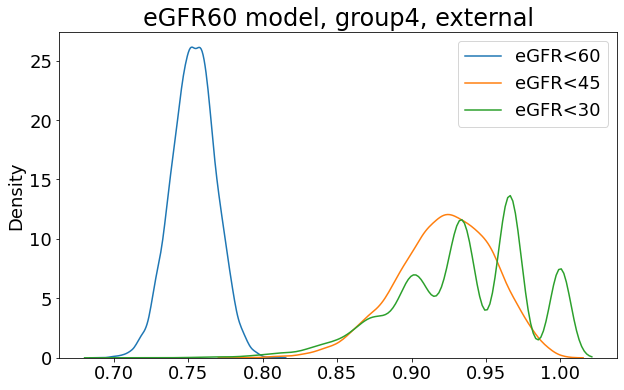

mean(ci): 0.75 (0.72-0.78), median:0.75
mean(ci): 0.92 (0.85-0.98), median:0.92
mean(ci): 0.93 (0.84-1.00), median:0.94


In [102]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(se_g4_60_ev, label='eGFR<60') 
sns.kdeplot(se_g4_45_ev, label='eGFR<45') 
sns.kdeplot(se_g4_30_ev, label='eGFR<30') 
plt.title("eGFR60 model, group4, external", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

cical(se_g4_60_ev)
cical(se_g4_45_ev)
cical(se_g4_30_ev)

### group5, high prevalence

In [103]:
X_test_g5_ev['pred'] = np.where(X_test_g5_ev['prob']>=0.81, 1, 0)
X_test_g5_ev['pred'].value_counts()

print('external validation')
#60
X_test_g5_60_ev = X_test_g5_ev.query('eGFR_ckd<60')
X_test_g5_60_ev['acc'] = X_test_g5_60_ev['eGFR_ab'] == X_test_g5_60_ev['pred']
print('60all: %.f right: %.f ratio: %.1f' % 
      (sum(X_test_g5_60_ev['wt']), sum(X_test_g5_60_ev.query('acc==1')['wt']), sum(X_test_g5_60_ev.query('acc==1')['wt'])/sum(X_test_g5_60_ev['wt'])*100))

#45
X_test_g5_45_ev = X_test_g5_ev.query('eGFR_ckd<45')
X_test_g5_45_ev['eGFR_ab45'] = np.where(X_test_g5_45_ev['eGFR_ckd']<45,1,0)
X_test_g5_45_ev['acc'] = X_test_g5_45_ev['eGFR_ab'] == X_test_g5_45_ev['pred']
print('45all: %.f right: %.f ratio: %.1f' % 
      (sum(X_test_g5_45_ev['wt']), sum(X_test_g5_45_ev.query('acc==1')['wt']), sum(X_test_g5_45_ev.query('acc==1')['wt'])/sum(X_test_g5_45_ev['wt'])*100))

#30
X_test_g5_30_ev = X_test_g5_ev.query('eGFR_ckd<30')
X_test_g5_30_ev['eGFR_ab30'] = np.where(X_test_g5_30_ev['eGFR_ckd']<30,1,0)
X_test_g5_30_ev['acc'] = X_test_g5_30_ev['eGFR_ab'] == X_test_g5_30_ev['pred']
print('30all: %.f right: %.f ratio: %.1f' % 
      (sum(X_test_g5_30_ev['wt']), sum(X_test_g5_30_ev.query('acc==1')['wt']), sum(X_test_g5_30_ev.query('acc==1')['wt'])/sum(X_test_g5_30_ev['wt'])*100))

external validation
60all: 363555 right: 223716 ratio: 61.5
45all: 89872 right: 66135 ratio: 73.6
30all: 21733 right: 18201 ratio: 83.7


In [104]:
# test set
data = X_test_g5_ev

# configure bootstrap
n_iterations = 10000
#n_size = len(data)

# run bootstrap
se_g5_60_ev = []
se_g5_45_ev = []
se_g5_30_ev = []

with tqdm.tqdm(total=n_iterations) as pbar:
    for i in range(n_iterations):
        # 60
        boot = resample(data, n_samples=len(data), replace=True, 
                        #stratify=data['eGFR_ab']
                       )
        boot['acc'] = boot['eGFR_ab'] == boot['pred']
        se = sum(boot.query('acc==1')['wt'])/sum(boot['wt'])
        se_g5_60_ev.append(se)
        
        # 45
        data45 = data.query('eGFR_ckd<45')
        boot45 = resample(data45, n_samples=len(data45), replace=True)
        boot45['eGFR_ab45'] = np.where(boot45['eGFR_ckd']<45,1,0)
        boot45['acc45'] = boot45['eGFR_ab45'] == boot45['pred']
        se45 = sum(boot45.query('acc45==1')['wt'])/sum(boot45['wt'])
        se_g5_45_ev.append(se45)
        
        # 30
        data30 = data.query('eGFR_ckd<30')
        boot30 = resample(data30, n_samples=len(data30), replace=True)
        boot30['eGFR_ab30'] = np.where(boot30['eGFR_ckd']<30,1,0)
        boot30['acc30'] = boot30['eGFR_ab30'] == boot30['pred']
        se30 = sum(boot30.query('acc30==1')['wt'])/sum(boot30['wt'])
        se_g5_30_ev.append(se30)
        
        pbar.update()

100%|██████████| 10000/10000 [02:18<00:00, 72.31it/s]


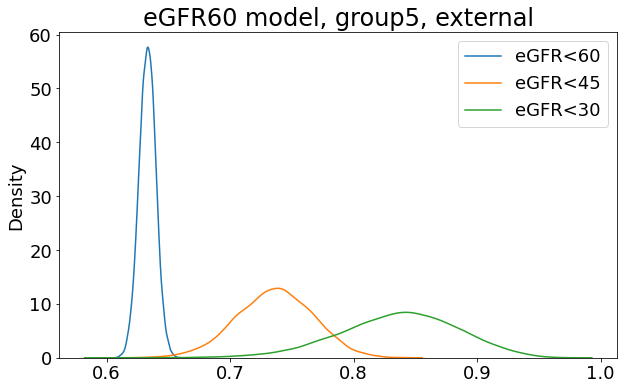

mean(ci): 0.63 (0.62-0.65), median:0.63
mean(ci): 0.74 (0.67-0.79), median:0.74
mean(ci): 0.84 (0.74-0.92), median:0.84


In [105]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(se_g5_60_ev, label='eGFR<60') 
sns.kdeplot(se_g5_45_ev, label='eGFR<45') 
sns.kdeplot(se_g5_30_ev, label='eGFR<30') 
plt.title("eGFR60 model, group5, external", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

cical(se_g5_60_ev)
cical(se_g5_45_ev)
cical(se_g5_30_ev)

In [106]:
df_se_trend_ev = pd.DataFrame({
    'eGFR' : ['eGFR<60', 'eGFR<45', 'eGFR<30',
             'eGFR<60', 'eGFR<45', 'eGFR<30',
             'eGFR<60', 'eGFR<45', 'eGFR<30',
             'eGFR<60', 'eGFR<45', 'eGFR<30',
             'eGFR<60', 'eGFR<45', 'eGFR<30',
             'eGFR<60', 'eGFR<45', 'eGFR<30'],
    
    'se'   : [0.88, 0.91, 0.89, 
              0.72, 0.83, 0.83, 
              0.72, 0.85, 0.82, 
              0.66, 0.71, 0.81, 
              0.75, 0.92, 0.93, 
              0.64, 0.73, 0.84],
    
    'lower' : [0.86, 0.87, 0.80,
               0.71, 0.77, 0.69,
               0.72, 0.79, 0.71,
               0.65, 0.65, 0.72,
               0.72, 0.85, 0.83,
               0.63, 0.67, 0.73],
    
    'upper' : [0.90, 0.95, 0.96,
               0.74, 0.90, 0.95,
               0.73, 0.90, 0.92,
               0.67, 0.76, 0.89,
               0.78, 0.98, 1.00,
               0.65, 0.79, 0.92],
    
    'group'  : ['All', 'All', 'All',
               'Diabetes', 'Diabetes', 'Diabetes',
               'Hypertension', 'Hypertension', 'Hypertension',
               'Old age', 'Old age', 'Old age',
               'Proteinuria','Proteinuria','Proteinuria',
               'High prev','High prev','High prev']
})
df_se_trend_ev['lower'] = df_se_trend_ev['se'] - df_se_trend_ev['lower']
df_se_trend_ev['upper'] = df_se_trend_ev['upper'] - df_se_trend_ev['se']
df_se_trend_ev

,eGFR,se,lower,upper,group
0,eGFR<60,0.88,0.02,0.02,All
1,eGFR<45,0.91,0.04,0.04,All
2,eGFR<30,0.89,0.09,0.07,All
3,eGFR<60,0.72,0.01,0.02,Diabetes
4,eGFR<45,0.83,0.06,0.07,Diabetes
5,eGFR<30,0.83,0.14,0.12,Diabetes
6,eGFR<60,0.72,0.00,0.01,Hypertension
7,eGFR<45,0.85,0.06,0.05,Hypertension
8,eGFR<30,0.82,0.11,0.10,Hypertension
9,eGFR<60,0.66,0.01,0.01,Old age


In [107]:
df_se_trend_sub_ev = df_se_trend_ev.query('group=="All"|group=="Old age"|group=="High prev"')
df_se_trend_sub_ev

,eGFR,se,lower,upper,group
0,eGFR<60,0.88,0.02,0.02,All
1,eGFR<45,0.91,0.04,0.04,All
2,eGFR<30,0.89,0.09,0.07,All
9,eGFR<60,0.66,0.01,0.01,Old age
10,eGFR<45,0.71,0.06,0.05,Old age
11,eGFR<30,0.81,0.09,0.08,Old age
15,eGFR<60,0.64,0.01,0.01,High prev
16,eGFR<45,0.73,0.06,0.06,High prev
17,eGFR<30,0.84,0.11,0.08,High prev


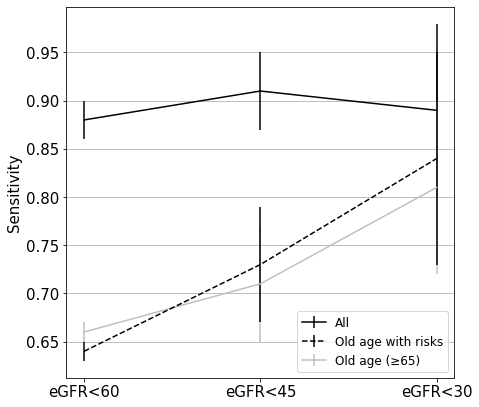

In [127]:
# trends of sensitivities plot
plt.rcParams["figure.figsize"] = (7,6)
fig,ax = plt.subplots()
#sns.set(style= "whitegrid")

df = df_se_trend_sub_ev
lvls = df.group.unique()
#for i in lvls:
#    ax.errorbar(x = df[df['group']==i]["eGFR"],
#                y=df[df['group']==i]["se"], 
#                yerr=[df[df['group']==i]["lower"], df[df['group']==i]["lower"]],
#               label=i)
    
ax.errorbar(x = df[df['group']=='All']["eGFR"],
            y=df[df['group']=='All']["se"], 
            yerr=[df[df['group']=='All']["lower"], df[df['group']=='All']["lower"]],
            label='All', color='k', linestyle='-')

ax.errorbar(x = df[df['group']=='Old age']["eGFR"],
            y=df[df['group']=='Old age']["se"], 
            yerr=[df[df['group']=='Old age']["lower"], df[df['group']=='Old age']["lower"]],
            label='Old age (≥65)', color='silver')

ax.errorbar(x = df[df['group']=='High prev']["eGFR"],
            y=df[df['group']=='High prev']["se"], 
            yerr=[df[df['group']=='High prev']["lower"], df[df['group']=='High prev']["lower"]],
            label='Old age with risks', color='k', linestyle='--')

#ax.axhline(y=0.5 , color='k', linestyle='--')
#ax.legend(loc=4, prop={'size':12})
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_ylabel('Sensitivity', fontsize=15)

handles, labels = plt.gca().get_legend_handles_labels()
order = [0,2,1]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc=4, fontsize=12)

#plt.show()

plt.grid(axis='y')
plt.tight_layout()

#plt.savefig('/home/danssa/proj_ua/images/5sub/old_sen_external.png', dpi=300)

# why external

## check subgroup cases

In [109]:
print('internal',len(X_test_g5) == len(X_test.query('dm==1|htn==1|he_upro>1').query('age>=65')))
print('external',len(X_test_g5_ev) == len(ev.query('dm==1|htn==1|he_upro>1').query('age>=65')))

internal True
external True


## density, distribution of probabilities

Text(0.5, 1.0, 'external, all')

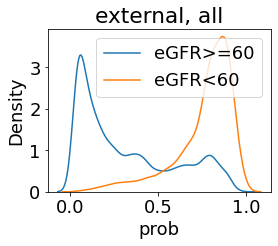

In [110]:
#sns.kdeplot(X_test_g2_ev['prob'], label='all')
plt.rcParams["figure.figsize"] = (4,3)
sns.kdeplot(X_test_bs_ev.query('eGFR_ab==0')['prob'], label='eGFR>=60')
sns.kdeplot(X_test_bs_ev.query('eGFR_ab==1')['prob'], label='eGFR<60')

plt.legend()
plt.title('external, all')

Text(0.5, 1.0, 'external, old age with risks')

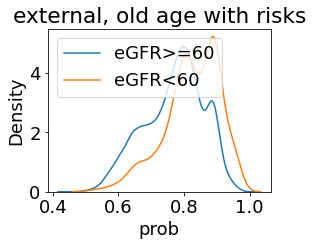

In [111]:
# from subset
sns.kdeplot(X_test_g5_ev.query('eGFR_ab==0')['prob'], label='eGFR>=60')
sns.kdeplot(X_test_g5_ev.query('eGFR_ab==1')['prob'], label='eGFR<60')

plt.legend()
plt.title('external, old age with risks')

Text(0.5, 1.0, 'external, old age')

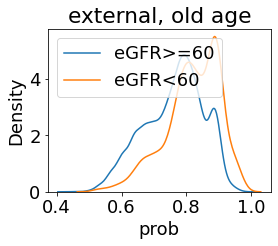

In [112]:
#sns.kdeplot(X_test_g2_ev['prob'], label='all')
sns.kdeplot(X_test_g3_ev.query('eGFR_ab==0')['prob'], label='eGFR>=60')
sns.kdeplot(X_test_g3_ev.query('eGFR_ab==1')['prob'], label='eGFR<60')

plt.legend()
plt.title('external, old age')

Text(0.5, 1.0, 'internal, all')

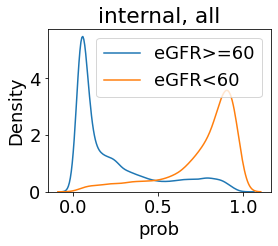

In [113]:
sns.kdeplot(X_test_bs.query('eGFR_ab==0')['prob'], label='eGFR>=60')
sns.kdeplot(X_test_bs.query('eGFR_ab==1')['prob'], label='eGFR<60')

plt.legend()
plt.title('internal, all')

Text(0.5, 1.0, 'internal, old age')

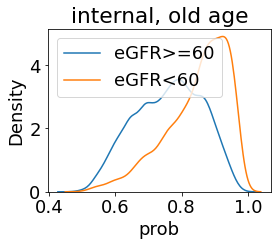

In [114]:
sns.kdeplot(X_test_g3.query('eGFR_ab==0')['prob'], label='eGFR>=60')
sns.kdeplot(X_test_g3.query('eGFR_ab==1')['prob'], label='eGFR<60')

plt.legend()
plt.title('internal, old age')

Text(0.5, 1.0, 'internal, old age with risks')

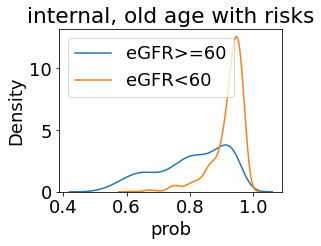

In [115]:
sns.kdeplot(X_test_g5.query('eGFR_ab==0')['prob'], label='eGFR>=60')
sns.kdeplot(X_test_g5.query('eGFR_ab==1')['prob'], label='eGFR<60')

plt.legend()
plt.title('internal, old age with risks')

## sub sub check

### diabetes

Text(0.5, 1.0, 'internal, diabetes, age>=65')

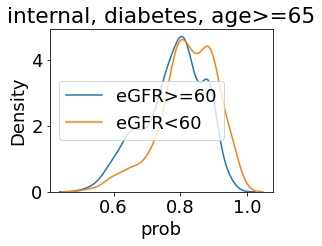

In [116]:
sns.kdeplot(X_test_g1_ev.query('age>=65').query('eGFR_ab==0')['prob'], label='eGFR>=60')
sns.kdeplot(X_test_g1_ev.query('age>=65').query('eGFR_ab==1')['prob'], label='eGFR<60')

plt.legend()
plt.title('internal, diabetes, age>=65')

In [117]:
#Youden’s J statistic. / J = Sensitivity + Specificity – 1
y_prob = X_test_g1_ev.query('age>=65')['prob']
y_test = X_test_g1_ev.query('age>=65')['eGFR_ab']
weight = X_test_g1_ev.query('age>=65')['wt']

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_prob, sample_weight=weight)
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('eGFR60 model, group1 + old age external')
print('AUC         : %.2f\nsensitivity : %.2f\nspecificity : %.2f\nThreshold   : %.2f' 
      % (roc_auc_score(y_test, y_prob, sample_weight=weight), tpr[ix], 1-fpr[ix], best_thresh))

print('\nClassification Report\n')
y_prob_pred = (y_prob >= best_thresh).astype(bool)
print(classification_report(y_test, y_prob_pred, target_names=['normal', 'abnormal'], sample_weight=weight))

eGFR60 model, group1 + old age external
AUC         : 0.64
sensitivity : 0.45
specificity : 0.75
Threshold   : 0.85

Classification Report

              precision    recall  f1-score   support

      normal       0.85      0.75      0.80 620589.8017202788
    abnormal       0.30      0.45      0.36 149299.2408626277

    accuracy                           0.69 769889.0425829065
   macro avg       0.58      0.60      0.58 769889.0425829065
weighted avg       0.74      0.69      0.71 769889.0425829065



Text(0.5, 1.0, 'internal, diabetes, age<65')

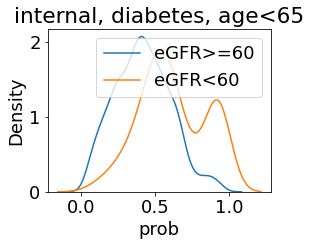

In [118]:
sns.kdeplot(X_test_g1_ev.query('age<65').query('eGFR_ab==0')['prob'], label='eGFR>=60')
sns.kdeplot(X_test_g1_ev.query('age<65').query('eGFR_ab==1')['prob'], label='eGFR<60')

plt.legend()
plt.title('internal, diabetes, age<65')

In [119]:
#Youden’s J statistic. / J = Sensitivity + Specificity – 1
y_prob = X_test_g1_ev.query('age<65')['prob']
y_test = X_test_g1_ev.query('age<65')['eGFR_ab']
weight = X_test_g1_ev.query('age<65')['wt']

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_prob, sample_weight=weight)
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('eGFR60 model, group1 + young age external')
print('AUC         : %.2f\nsensitivity : %.2f\nspecificity : %.2f\nThreshold   : %.2f' 
      % (roc_auc_score(y_test, y_prob, sample_weight=weight), tpr[ix], 1-fpr[ix], best_thresh))

print('\nClassification Report\n')
y_prob_pred = (y_prob >= best_thresh).astype(bool)
print(classification_report(y_test, y_prob_pred, target_names=['normal', 'abnormal'], sample_weight=weight))

eGFR60 model, group1 + young age external
AUC         : 0.75
sensitivity : 0.81
specificity : 0.57
Threshold   : 0.41

Classification Report

              precision    recall  f1-score   support

      normal       0.98      0.57      0.72 1048405.6307507047
    abnormal       0.11      0.81      0.19 66869.81464163633

    accuracy                           0.58 1115275.445392341
   macro avg       0.54      0.69      0.45 1115275.445392341
weighted avg       0.93      0.58      0.68 1115275.445392341



### hypertension

Text(0.5, 1.0, 'internal, hypertension, age>=65')

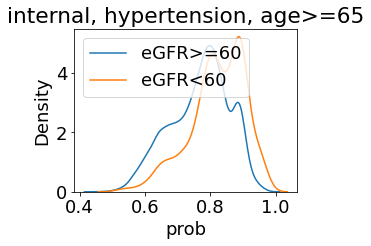

In [120]:
sns.kdeplot(X_test_g2_ev.query('age>=65').query('eGFR_ab==0')['prob'], label='eGFR>=60')
sns.kdeplot(X_test_g2_ev.query('age>=65').query('eGFR_ab==1')['prob'], label='eGFR<60')

plt.legend()
plt.title('internal, hypertension, age>=65')

In [121]:
#Youden’s J statistic. / J = Sensitivity + Specificity – 1
y_prob = X_test_g2_ev.query('age>=65')['prob']
y_test = X_test_g2_ev.query('age>=65')['eGFR_ab']
weight = X_test_g2_ev.query('age>=65')['wt']

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_prob, sample_weight=weight)
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('eGFR60 model, group2 + old age external')
print('AUC         : %.2f\nsensitivity : %.2f\nspecificity : %.2f\nThreshold   : %.2f' 
      % (roc_auc_score(y_test, y_prob, sample_weight=weight), tpr[ix], 1-fpr[ix], best_thresh))

print('\nClassification Report\n')
y_prob_pred = (y_prob >= best_thresh).astype(bool)
print(classification_report(y_test, y_prob_pred, target_names=['normal', 'abnormal'], sample_weight=weight))

eGFR60 model, group2 + old age external
AUC         : 0.68
sensitivity : 0.67
specificity : 0.59
Threshold   : 0.80

Classification Report

              precision    recall  f1-score   support

      normal       0.91      0.59      0.72 1773177.0314661986
    abnormal       0.22      0.67      0.34 311184.0157914155

    accuracy                           0.60 2084361.047257614
   macro avg       0.57      0.63      0.53 2084361.047257614
weighted avg       0.81      0.60      0.66 2084361.047257614



Text(0.5, 1.0, 'internal, hypertension, age<65')

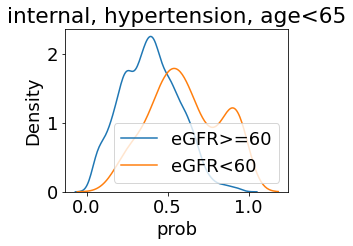

In [122]:
sns.kdeplot(X_test_g2_ev.query('age<65').query('eGFR_ab==0')['prob'], label='eGFR>=60')
sns.kdeplot(X_test_g2_ev.query('age<65').query('eGFR_ab==1')['prob'], label='eGFR<60')

plt.legend()
plt.title('internal, hypertension, age<65')

In [123]:
#Youden’s J statistic. / J = Sensitivity + Specificity – 1
y_prob = X_test_g2_ev.query('age<65')['prob']
y_test = X_test_g2_ev.query('age<65')['eGFR_ab']
weight = X_test_g2_ev.query('age<65')['wt']

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_prob, sample_weight=weight)
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('eGFR60 model, group2 + young age external')
print('AUC         : %.2f\nsensitivity : %.2f\nspecificity : %.2f\nThreshold   : %.2f' 
      % (roc_auc_score(y_test, y_prob, sample_weight=weight), tpr[ix], 1-fpr[ix], best_thresh))

print('\nClassification Report\n')
y_prob_pred = (y_prob >= best_thresh).astype(bool)
print(classification_report(y_test, y_prob_pred, target_names=['normal', 'abnormal'], sample_weight=weight))

eGFR60 model, group2 + young age external
AUC         : 0.78
sensitivity : 0.66
specificity : 0.77
Threshold   : 0.50

Classification Report

              precision    recall  f1-score   support

      normal       0.98      0.77      0.86 2700181.445901599
    abnormal       0.11      0.66      0.19 119418.30286821655

    accuracy                           0.76 2819599.7487698155
   macro avg       0.55      0.72      0.53 2819599.7487698155
weighted avg       0.94      0.76      0.83 2819599.7487698155



In [124]:
print('diabetes group mean age\ninternal:%.1f(%.f) external:%.1f(%.f)' % (mean(X_test_g1['age']), std(X_test_g1['age']), mean(X_test_g1_ev['age']), std(X_test_g1_ev['age'])))
print('\nhypertension group mean age\ninternal:%.1f(%.f) external:%.1f(%.f)' % (mean(X_test_g2['age']), std(X_test_g2['age']), mean(X_test_g2_ev['age']), std(X_test_g2_ev['age'])))
print('\nold age group mean age\ninternal:%.1f(%.f) external:%.1f(%.f)' % (mean(X_test_g3['age']), std(X_test_g3['age']), mean(X_test_g3_ev['age']), std(X_test_g3_ev['age'])))
print('\nold age with risks group mean age\ninternal:%.1f(%.f) external:%.1f(%.f)' % (mean(X_test_g5['age']), std(X_test_g5['age']), mean(X_test_g5_ev['age']), std(X_test_g5_ev['age'])))

diabetes group mean age
internal:55.0(11) external:63.8(10)

hypertension group mean age
internal:53.4(12) external:64.1(10)

old age group mean age
internal:72.9(6) external:71.1(4)

old age with risks group mean age
internal:73.1(6) external:71.4(4)
